# Model Predictions
## Predicting Rates of Chronic Absenteeism

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier 
import datetime
from pandas_profiling import ProfileReport

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn import tree, metrics
from io import StringIO  
from IPython.display import Image  
#import pydotplus

import matplotlib.style as style
style.use('fivethirtyeight')

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
#load data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed'
os.chdir(path) 

df_classifier = pd.read_csv('more_variables_attendance_2013_18_classifier.csv', dtype={'District_Number': object})

df_regressor = pd.read_csv('more_variables_attendance_2013_18_regressor.csv', dtype={'District_Number': object})

df_18_19 = pd.read_csv('more_variables_attendance_2018_19.csv', dtype={'District_Number': object})

In [4]:
#check to ensure District Number is correctly an object, not int
df_classifier.dtypes

Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Chronically_Absent_Next_Year                  object
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [5]:
df_18_19.dtypes

Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
Chronically_Absent_Next_Year                 float64
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [6]:
df_regressor.dtypes

Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [7]:
#create dummy variables for the two data frames
df_regressor_dummies = pd.get_dummies(df_regressor.drop(columns=['Year']))

#remove target variable from classification data, so it does not get turned into a dummy variable
df_classifier_dummies = pd.get_dummies(df_classifier.drop(columns=['Chronically_Absent_Next_Year', 'Year']))

#save target variable for classification
target_classifier = df_classifier['Chronically_Absent_Next_Year']

print(df_classifier_dummies.shape)

(448835, 68)


## Regression Model

In [8]:
#define variables for regressor
X = df_regressor_dummies.drop(columns=['Next Year % Chronically Absent'])
y = df_regressor_dummies['Next Year % Chronically Absent']

In [9]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
#load model

path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/models'
os.chdir(path)
filename_reg = 'rf_regressor.sav'

# load the model from disk
#accuracy matches before
loaded_model_reg = pickle.load(open(filename_reg, 'rb'))
result = loaded_model_reg.score(X_test, y_test)
print(result)

0.825315035556083


In [12]:
#fit regession model on all available data
loaded_model_reg.fit(X, y)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 111, 122, 133,
                                                         144, 155, 166, 177,
                                                         188, 200]},
                   random_state=42)

## Classification Model 

In [13]:
#define variables for classifier
X_c = df_classifier_dummies
y_c = target_classifier

In [14]:
#Time series Train test split for the 5 school years years
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, random_state = 0) 

In [15]:
#load model

path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/models'
os.chdir(path)
filename = 'rf_classifier_improved_minus_year.sav'

# load the model from disk
#accuracy matches before
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8484078817207176


### Refit Classification Model on All Available Data

In [16]:
loaded_model.fit(X_c, y_c)

RandomForestClassifier()

### Calculate Expected Chronic Absenteeism for 2019-2020 school year From The Model 

In [17]:
#define functions to get NaNs as % 
def NaNs_as_percent(dataframe):
    '''show % NaNs for each column'''
    print(dataframe.isna().sum()/len(dataframe)*100)

In [18]:
#check NaNs of 2018-19 data
NaNs_as_percent(df_18_19)

Grade                                          0.000000
Year                                           0.000000
Demographic Variable                           0.000000
% Attendance                                   0.000000
% Chronically Absent                           0.000000
Next Year % Chronically Absent               100.000000
Chronically_Absent_Next_Year                 100.000000
District_Number                                0.000000
% Attendance - diff from 5 yr avg              2.441424
% Attendance - diff from 2 yr avg              4.662672
% Chronically Absent - diff from 5 yr avg      2.441424
% Chronically Absent - diff from 2 yr avg      4.662672
dtype: float64


In [19]:
#drop NaN rows, for only the rows where target classification variable is NOT NaN
df_18_19.dropna(subset=['% Attendance - diff from 5 yr avg', '% Attendance - diff from 2 yr avg', '% Chronically Absent - diff from 5 yr avg', '% Chronically Absent - diff from 2 yr avg'], inplace=True)

In [20]:
#from regression model, drop column that was used as classification target variable
df_18_19_reg = df_18_19.drop(columns=['Chronically_Absent_Next_Year'])

#from classification model drop column that was used as regression target variable
df_18_19.drop(columns=['Next Year % Chronically Absent'], inplace=True)

In [21]:
#check NaNs were dealt with correctly
NaNs_as_percent(df_18_19)

Grade                                          0.0
Year                                           0.0
Demographic Variable                           0.0
% Attendance                                   0.0
% Chronically Absent                           0.0
Chronically_Absent_Next_Year                 100.0
District_Number                                0.0
% Attendance - diff from 5 yr avg              0.0
% Attendance - diff from 2 yr avg              0.0
% Chronically Absent - diff from 5 yr avg      0.0
% Chronically Absent - diff from 2 yr avg      0.0
dtype: float64


In [22]:
NaNs_as_percent(df_18_19_reg)

Grade                                          0.0
Year                                           0.0
Demographic Variable                           0.0
% Attendance                                   0.0
% Chronically Absent                           0.0
Next Year % Chronically Absent               100.0
District_Number                                0.0
% Attendance - diff from 5 yr avg              0.0
% Attendance - diff from 2 yr avg              0.0
% Chronically Absent - diff from 5 yr avg      0.0
% Chronically Absent - diff from 2 yr avg      0.0
dtype: float64


In [23]:
#create X and y variables for years 2019-2020
X_18_19 = df_18_19.drop(['Chronically_Absent_Next_Year', 'Year'], axis=1)
y_18_19 = df_18_19['Chronically_Absent_Next_Year']

X_18_19_reg = df_18_19_reg.drop(['Next Year % Chronically Absent', 'Year'], axis=1)
y_18_19_reg = df_18_19_reg['Next Year % Chronically Absent']

In [24]:
X_18_19.dtypes

Grade                                         object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [25]:
X_18_19_reg.dtypes

Grade                                         object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [26]:
#turn categorical variables into binary for predicting with get dummies
X_18_19_dummy = pd.get_dummies(X_18_19)

X_18_19_reg_dummy = pd.get_dummies(X_18_19_reg)

In [27]:
#predict next year's vacancy rate (2019-20) for school year 2018-19 (classification model)
pred_18_19 = loaded_model.predict(X_18_19_dummy)

In [28]:
#predict next year's vacancy rate (2019-20) for school year 2018-19 (regression model)
pred_18_19_reg = loaded_model_reg.predict(X_18_19_reg_dummy)

In [29]:
pred_18_19

array(['Medium', 'High', 'Medium', ..., 'High', 'High', 'High'],
      dtype=object)

In [30]:
pred_18_19_reg

array([22.53212543, 45.3488186 , 29.61885553, ..., 52.57580562,
       59.88150694, 55.29731473])

In [31]:
#create new columns of predictedvalues
X_18_19['Chronically_Absent_Next_Year'] = pred_18_19
X_18_19_reg['Next Year % Chronically Absent'] = pred_18_19_reg
X_18_19

Grade Demographic Variable  % Attendance  \
0               All Grades         All Students          92.6   
1       PK in K-12 Schools         All Students          88.4   
2                       0K         All Students          91.9   
3                        1         All Students          90.7   
4                        2         All Students          94.0   
...                    ...                  ...           ...   
102640                  10              Not ELL          84.2   
102641                  11                  ELL          79.8   
102642                  11              Not ELL          86.0   
102643                  12                  ELL          80.6   
102644                  12              Not ELL          84.4   

        % Chronically Absent District_Number  \
0                       24.2              01   
1                       50.0              01   
2                       28.6              01   
3                       28.6              01   
4                       11.8              01   
...                      ...             ...   
102640                  52.8              75   
102641                  66.7              75   
102642                  55.2              75   
102643                  66.7              75   
102644                  47.4              75   

        % Attendance - diff from 5 yr avg  % Attendance - diff from 2 yr avg  \
0                               -0.460000                              -1.05   
1                               -0.375000                              -4.20   
2                                0.180000                              -0.65   
3                               -2.460000                              -3.25   
4                                0.380000                               0.25   
...                                   ...                                ...   
102640                          -1.133333                              -1.70   
102641                          -6.800000                              -5.10   
102642                           2.966667                               3.10   
102643                          -2.280000                              -1.95   
102644                           1.020000                               1.30   

        % Chronically Absent - diff from 5 yr avg  \
0                                       -0.120000   
1                                        2.325000   
2                                       -1.960000   
3                                        2.960000   
4                                       -7.740000   
...                                           ...   
102640                                   4.066667   
102641                                  13.033333   
102642                                   3.900000   
102643                                   2.980000   
102644                                  -8.040000   

        % Chronically Absent - diff from 2 yr avg Chronically_Absent_Next_Year  
0                                            2.25                       Medium  
1                                           27.80                         High  
2                                           -1.85                       Medium  
3                                           12.15                       Medium  
4                                           -8.80                       Medium  
...                                           ...                          ...  
102640                                       7.60                         High  
102641                                       4.80                         High  
102642                                       1.70                         High  
102643                                       4.05                         High  
102644                                      -5.95                         High  

[97859 rows x 10 columns]

In [32]:
X_18_19_reg

Grade Demographic Variable  % Attendance  \
0               All Grades         All Students          92.6   
1       PK in K-12 Schools         All Students          88.4   
2                       0K         All Students          91.9   
3                        1         All Students          90.7   
4                        2         All Students          94.0   
...                    ...                  ...           ...   
102640                  10              Not ELL          84.2   
102641                  11                  ELL          79.8   
102642                  11              Not ELL          86.0   
102643                  12                  ELL          80.6   
102644                  12              Not ELL          84.4   

        % Chronically Absent District_Number  \
0                       24.2              01   
1                       50.0              01   
2                       28.6              01   
3                       28.6              01   
4                       11.8              01   
...                      ...             ...   
102640                  52.8              75   
102641                  66.7              75   
102642                  55.2              75   
102643                  66.7              75   
102644                  47.4              75   

        % Attendance - diff from 5 yr avg  % Attendance - diff from 2 yr avg  \
0                               -0.460000                              -1.05   
1                               -0.375000                              -4.20   
2                                0.180000                              -0.65   
3                               -2.460000                              -3.25   
4                                0.380000                               0.25   
...                                   ...                                ...   
102640                          -1.133333                              -1.70   
102641                          -6.800000                              -5.10   
102642                           2.966667                               3.10   
102643                          -2.280000                              -1.95   
102644                           1.020000                               1.30   

        % Chronically Absent - diff from 5 yr avg  \
0                                       -0.120000   
1                                        2.325000   
2                                       -1.960000   
3                                        2.960000   
4                                       -7.740000   
...                                           ...   
102640                                   4.066667   
102641                                  13.033333   
102642                                   3.900000   
102643                                   2.980000   
102644                                  -8.040000   

        % Chronically Absent - diff from 2 yr avg  \
0                                            2.25   
1                                           27.80   
2                                           -1.85   
3                                           12.15   
4                                           -8.80   
...                                           ...   
102640                                       7.60   
102641                                       4.80   
102642                                       1.70   
102643                                       4.05   
102644                                      -5.95   

        Next Year % Chronically Absent  
0                            22.532125  
1                            45.348819  
2                            29.618856  
3                            22.468107  
4                            20.259015  
...                                ...  
102640                       48.757613  
102641                       52.288065  
102642                       52.575806  
102643            

In [33]:
#get labels for school name & DBN
attendance = pd.read_csv('/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/interim/attendance_for_final_labels.csv', dtype={'District_Number': object})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [34]:
attendance.head()

DBN                School Name               Grade     Year  \
0  01M015  P.S. 015 Roberto Clemente          All Grades  2013-14   
1  01M015  P.S. 015 Roberto Clemente  PK in K-12 Schools  2013-14   
2  01M015  P.S. 015 Roberto Clemente                  0K  2013-14   
3  01M015  P.S. 015 Roberto Clemente                   1  2013-14   
4  01M015  P.S. 015 Roberto Clemente                   2  2013-14   

  Demographic Variable  # Days Absent  # Days Present  % Attendance  \
0         All Students         2783.0         32020.0          92.0   
1         All Students          560.0          4151.0          88.1   
2         All Students          659.0          6414.0          90.7   
3         All Students          525.0          6214.0          92.2   
4         All Students          308.0          3680.0          92.3   

   % Chronically Absent  Next Year % Chronically Absent  \
0                  26.9                            23.4   
1                  53.3                            65.2   
2                  29.5                            30.0   
3                  31.0                            18.8   
4                  20.0                            21.9   

  Chronically_Absent_Next_Year District_Number Borough_Code  School_Number  \
0                       Medium              01            M             15   
1                         High              01            M             15   
2                       Medium              01            M             15   
3                       Medium              01            M             15   
4                       Medium              01            M             15   

  Borough_Name  % Attendance - diff from 5 yr avg  \
0    Manhattan                             -1.060   
1    Manhattan                             -0.675   
2    Manhattan                             -1.020   
3    Manhattan                             -0.960   
4    Manhattan                             -1.320   

   % Attendance - diff from 2 yr avg  \
0                              -1.65   
1                              -4.50   
2                              -1.85   
3                              -1.75   
4                              -1.45   

   % Chronically Absent - diff from 5 yr avg  \
0                                      2.580   
1                                      5.625   
2                                     -1.060   
3                                      5.360   
4                                      0.460   

   % Chronically Absent - diff from 2 yr avg  
0                                       4.95  
1                                      31.10  
2                                      -0.95  
3                                      14.55  
4                                      -0.60

In [35]:
attendance.dtypes

DBN                                           object
School Name                                   object
Grade                                         object
Year                                          object
Demographic Variable                          object
# Days Absent                                float64
# Days Present                               float64
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
Chronically_Absent_Next_Year                  object
District_Number                               object
Borough_Code                                  object
School_Number                                  int64
Borough_Name                                  object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    f

In [36]:
#prepare attendance data for merge with 'Next Year's Chronic Absenteesim' predictions
attendance = attendance.drop(columns=['Borough_Code', 'School_Number', '# Days Absent', '# Days Present'])

In [37]:
attendance.dtypes

DBN                                           object
School Name                                   object
Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
Chronically_Absent_Next_Year                  object
District_Number                               object
Borough_Name                                  object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [38]:
NaNs_as_percent(attendance[attendance.Year == '2018-19'])

DBN                                            0.000000
School Name                                    0.000000
Grade                                          0.000000
Year                                           0.000000
Demographic Variable                           0.000000
% Attendance                                   0.000000
% Chronically Absent                           0.000000
Next Year % Chronically Absent               100.000000
Chronically_Absent_Next_Year                 100.000000
District_Number                                0.000000
Borough_Name                                   0.000000
% Attendance - diff from 5 yr avg              2.441424
% Attendance - diff from 2 yr avg              4.662672
% Chronically Absent - diff from 5 yr avg      2.441424
% Chronically Absent - diff from 2 yr avg      4.662672
dtype: float64


In [39]:
#drop NaN rows, for only the rows where target classification variable is NOT NaN
attendance.dropna(subset=['% Attendance - diff from 5 yr avg', '% Attendance - diff from 2 yr avg', '% Chronically Absent - diff from 5 yr avg', '% Chronically Absent - diff from 2 yr avg'], inplace=True)

In [40]:
#check if lens match up 
print(len(attendance[attendance.Year == '2018-19']))
print(len(pred_18_19))
print(len(pred_18_19_reg))

97859
97859
97859


In [41]:
#subset attendance to year 2018-2019
attendance_18_19 = attendance[attendance.Year == '2018-19']
attendance_18_19 = attendance_18_19.drop(columns=['Next Year % Chronically Absent', 'Chronically_Absent_Next_Year'])

In [42]:
attendance_18_19.head()

DBN                School Name               Grade     Year  \
500771  01M015  P.S. 015 Roberto Clemente          All Grades  2018-19   
500772  01M015  P.S. 015 Roberto Clemente  PK in K-12 Schools  2018-19   
500773  01M015  P.S. 015 Roberto Clemente                  0K  2018-19   
500774  01M015  P.S. 015 Roberto Clemente                   1  2018-19   
500775  01M015  P.S. 015 Roberto Clemente                   2  2018-19   

       Demographic Variable  % Attendance  % Chronically Absent  \
500771         All Students          92.6                  24.2   
500772         All Students          88.4                  50.0   
500773         All Students          91.9                  28.6   
500774         All Students          90.7                  28.6   
500775         All Students          94.0                  11.8   

       District_Number Borough_Name  % Attendance - diff from 5 yr avg  \
500771              01    Manhattan                             -0.460   
500772              01    Manhattan                             -0.375   
500773              01    Manhattan                              0.180   
500774              01    Manhattan                             -2.460   
500775              01    Manhattan                              0.380   

        % Attendance - diff from 2 yr avg  \
500771                              -1.05   
500772                              -4.20   
500773                              -0.65   
500774                              -3.25   
500775                               0.25   

        % Chronically Absent - diff from 5 yr avg  \
500771                                     -0.120   
500772                                      2.325   
500773                                     -1.960   
500774                                      2.960   
500775                                     -7.740   

        % Chronically Absent - diff from 2 yr avg  
500771                                       2.25  
500772                                      27.80  
500773                                      -1.85  
500774                                      12.15  
500775                                      -8.80

In [43]:
# added predicted values for next year onto 2018-19 data set
attendance_18_19['Chronically_Absent_Next_Year'] = pred_18_19
attendance_18_19['Next Year % Chronically Absent'] = pred_18_19_reg

In [44]:
attendance_18_19

DBN                School Name               Grade     Year  \
500771  01M015  P.S. 015 Roberto Clemente          All Grades  2018-19   
500772  01M015  P.S. 015 Roberto Clemente  PK in K-12 Schools  2018-19   
500773  01M015  P.S. 015 Roberto Clemente                  0K  2018-19   
500774  01M015  P.S. 015 Roberto Clemente                   1  2018-19   
500775  01M015  P.S. 015 Roberto Clemente                   2  2018-19   
...        ...                        ...                 ...      ...   
603411  75X811                  P.S. X811                  10  2018-19   
603412  75X811                  P.S. X811                  11  2018-19   
603413  75X811                  P.S. X811                  11  2018-19   
603414  75X811                  P.S. X811                  12  2018-19   
603415  75X811                  P.S. X811                  12  2018-19   

       Demographic Variable  % Attendance  % Chronically Absent  \
500771         All Students          92.6                  24.2   
500772         All Students          88.4                  50.0   
500773         All Students          91.9                  28.6   
500774         All Students          90.7                  28.6   
500775         All Students          94.0                  11.8   
...                     ...           ...                   ...   
603411              Not ELL          84.2                  52.8   
603412                  ELL          79.8                  66.7   
603413              Not ELL          86.0                  55.2   
603414                  ELL          80.6                  66.7   
603415              Not ELL          84.4                  47.4   

       District_Number Borough_Name  % Attendance - diff from 5 yr avg  \
500771              01    Manhattan                          -0.460000   
500772              01    Manhattan                          -0.375000   
500773              01    Manhattan                           0.180000   
500774              01    Manhattan                          -2.460000   
500775              01    Manhattan                           0.380000   
...                ...          ...                                ...   
603411              75        Bronx                          -1.133333   
603412              75        Bronx                          -6.800000   
603413              75        Bronx                           2.966667   
603414              75        Bronx                          -2.280000   
603415              75        Bronx                           1.020000   

        % Attendance - diff from 2 yr avg  \
500771                              -1.05   
500772                              -4.20   
500773                              -0.65   
500774                              -3.25   
500775                               0.25   
...                                   ...   
603411                              -1.70   
603412                              -5.10   
603413                               3.10   
603414                              -1.95   
603415                               1.30   

        % Chronically Absent - diff from 5 yr avg  \
500771                                  -0.120000   
500772                                   2.325000   
500773                                  -1.960000   
500774                                   2.960000   
500775                                  -7.740000   
...                                           ...   
603411                                   4.066667   
603412                                  13.033333   
603413                                   3.900000   
603414                                   2.980000   
603415                                  -8.040000   

        % Chronically Absent - diff from 2 yr avg  \
500771                                       2.25   
500772                                      27.80   
500773                                      -1.85   
500774                                

## Explore Projected 2019-20 Chronic Absenteeism Data

<AxesSubplot:xlabel='Borough_Name', ylabel='Next Year % Chronically Absent'>

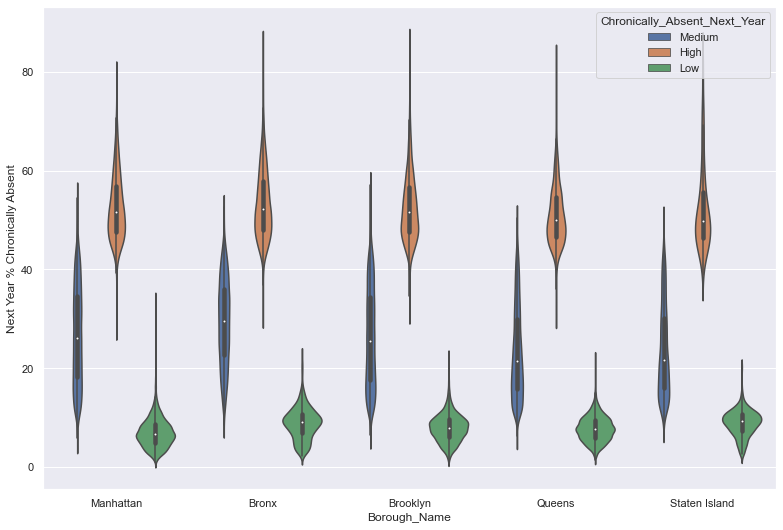

In [45]:
#look at violin plots of borough name vs. Next Year % Chronically Absent by class (High, Medium, Low). 
#Seems like most of the variation is in the borough's 'Medium' class. 
#This may be a good area to target in interventions
sns.violinplot(x='Borough_Name', y='Next Year % Chronically Absent', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

<AxesSubplot:xlabel='Demographic Variable', ylabel='Next Year % Chronically Absent'>

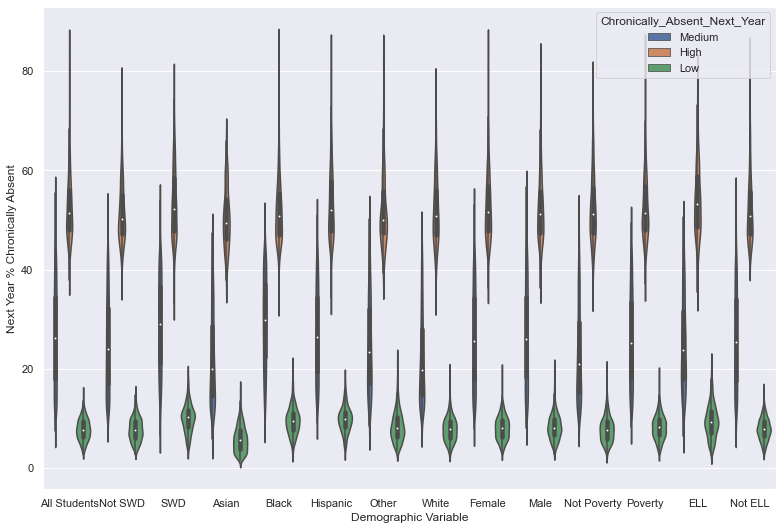

In [154]:
#- look at violin plots of Demographic Variable vs. Next Year % Chronically Absent by class (High, Medium, Low). 
#Again it seems like most of the variation is in the 'Medium' class. 
sns.violinplot(x='Demographic Variable', y='Next Year % Chronically Absent', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

<AxesSubplot:xlabel='Demographic Variable', ylabel='Next Year % Chronically Absent'>

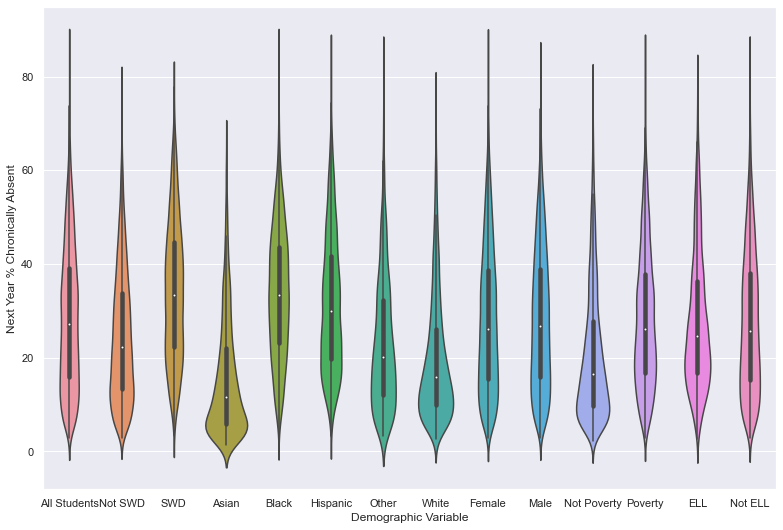

In [155]:
#- look at violin plots of Demographic Variable vs. vs. Next Year % Chronically Absent. 
#Seems like 'Asian', 'White', 'Other' (Race), and 'Not Poverty' students are significantly below the average. 
#While SWD (Students with Disabilities), Black and Hispanic students seem to be signifiantly above the average.

sns.violinplot(x='Demographic Variable', y='Next Year % Chronically Absent', data=attendance_18_19)

<AxesSubplot:xlabel='District_Number', ylabel='Next Year % Chronically Absent'>

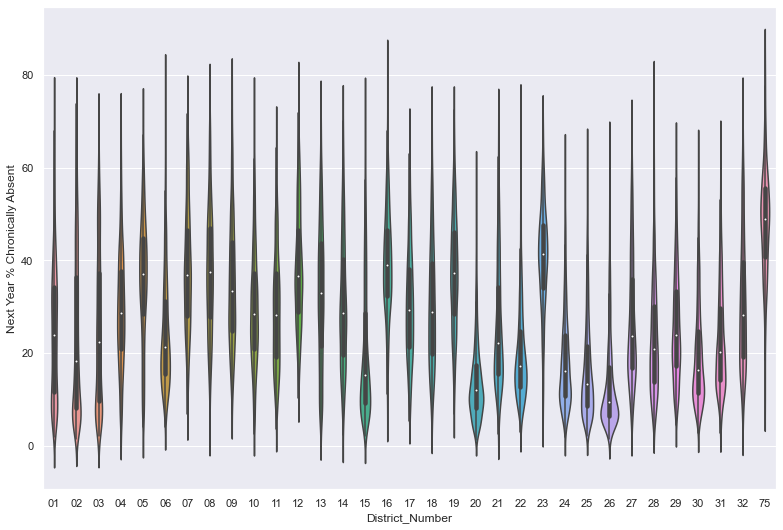

In [157]:
#look at violin plot of District_Number vs. Next Year % Chronically Absent

sns.violinplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19)

<AxesSubplot:xlabel='% Attendance', ylabel='% Chronically Absent'>

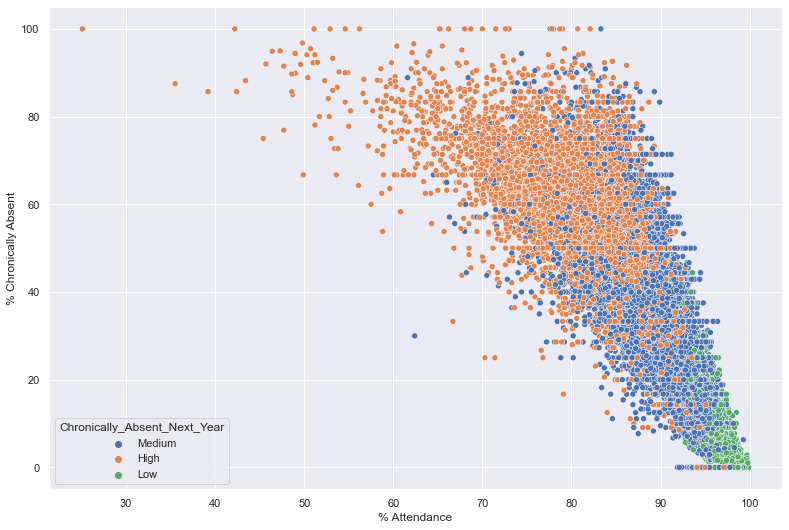

In [40]:
#look at scatterplot '% Attendance' vs. '% Chronically Absent' colored by 'Chronically_Absent_Next_Year'. 
#You can see the overlap/variation of the 'Medium' class


sns.scatterplot(x='% Attendance', y='% Chronically Absent', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

<AxesSubplot:xlabel='% Attendance - diff from 5 yr avg', ylabel='% Chronically Absent - diff from 5 yr avg'>

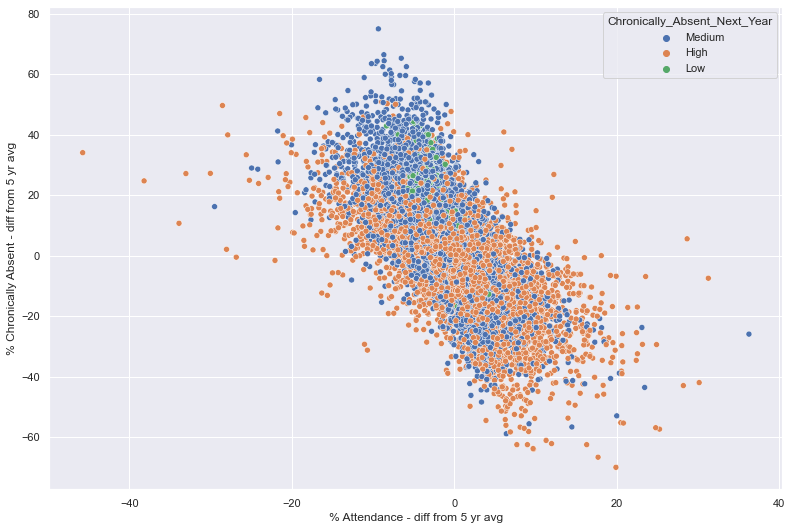

In [41]:
#scatterplot of '% Attendance - diff from 5 yr avg' vs. '% Chronically Absent - diff from 5 yr avg', 
#colored by 'Chronically_Absent_Next_Year

sns.scatterplot(x='% Attendance - diff from 5 yr avg', y='% Chronically Absent - diff from 5 yr avg', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

<AxesSubplot:xlabel='% Attendance - diff from 2 yr avg', ylabel='% Chronically Absent - diff from 2 yr avg'>

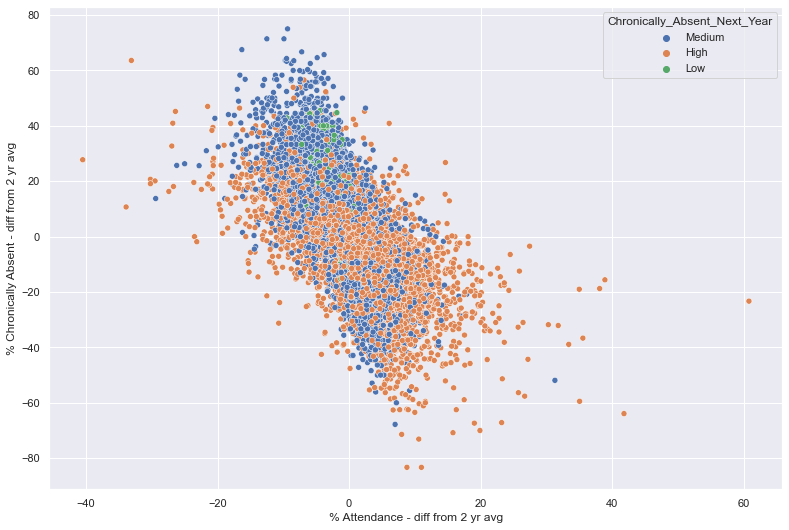

In [42]:
#- scatterplot '% Attendance - diff from 2 yr avg' vs. '% Chronically Absent - diff from 2 yr avg', 
#colored by 'Chronically_Absent_Next_Year'
#These plots show there is a lot of year to year variation in the 'High' group in how they differ from their own 2 & 5 year averages. 
#Seeming to show this group would potentially benefit from a concerted intervention.

sns.scatterplot(x='% Attendance - diff from 2 yr avg', y='% Chronically Absent - diff from 2 yr avg', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

In [43]:
attendance_18_19.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Demographic Variable',
       '% Attendance', '% Chronically Absent', 'District_Number',
       'Borough_Name', '% Attendance - diff from 5 yr avg',
       '% Attendance - diff from 2 yr avg',
       '% Chronically Absent - diff from 5 yr avg',
       '% Chronically Absent - diff from 2 yr avg',
       'Chronically_Absent_Next_Year'],
      dtype='object')

In [158]:
attendance_18_19.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Demographic Variable',
       '% Attendance', '% Chronically Absent', 'District_Number',
       'Borough_Name', '% Attendance - diff from 5 yr avg',
       '% Attendance - diff from 2 yr avg',
       '% Chronically Absent - diff from 5 yr avg',
       '% Chronically Absent - diff from 2 yr avg',
       'Chronically_Absent_Next_Year', 'Next Year % Chronically Absent'],
      dtype='object')

In [45]:
def see_target_interactions(dataframe, target_variable):
    '''vizualize scatterplot to see interaction between target variable and each variable'''
    for col in dataframe.columns:
        sns.scatterplot(x=col, y=target_variable, data=dataframe)
        plt.show()

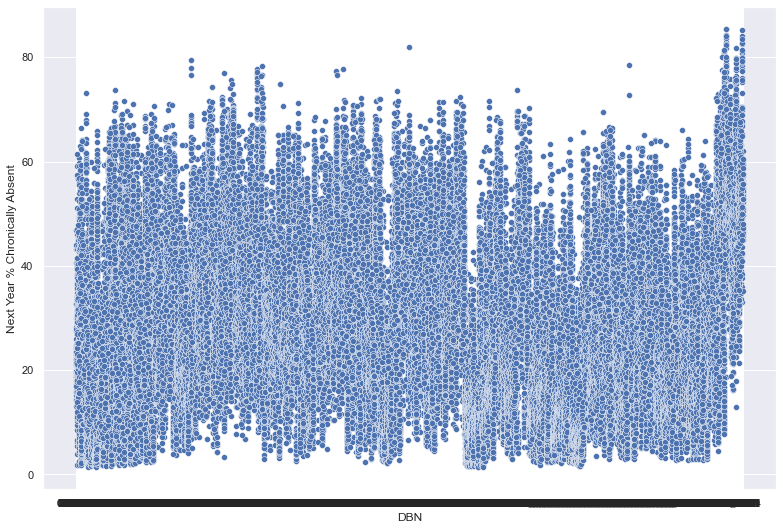

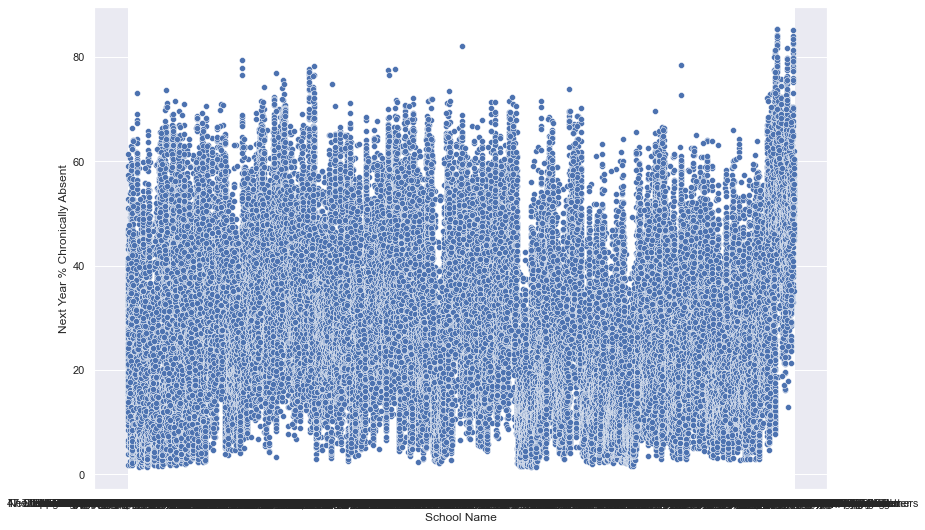

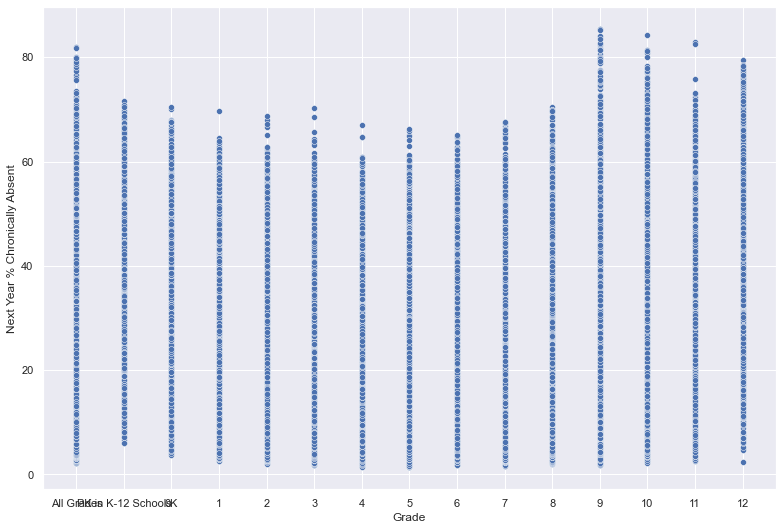

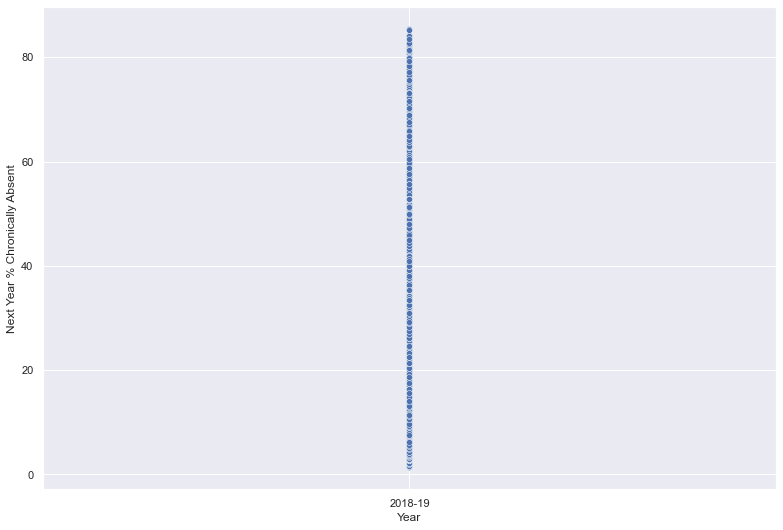

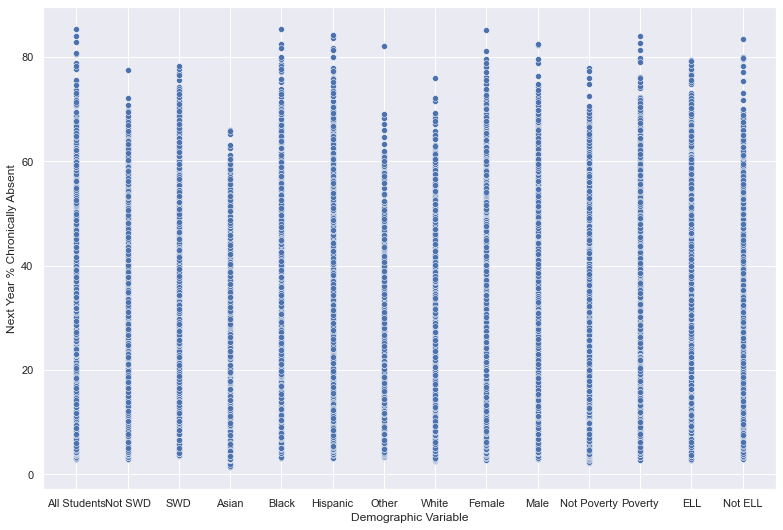

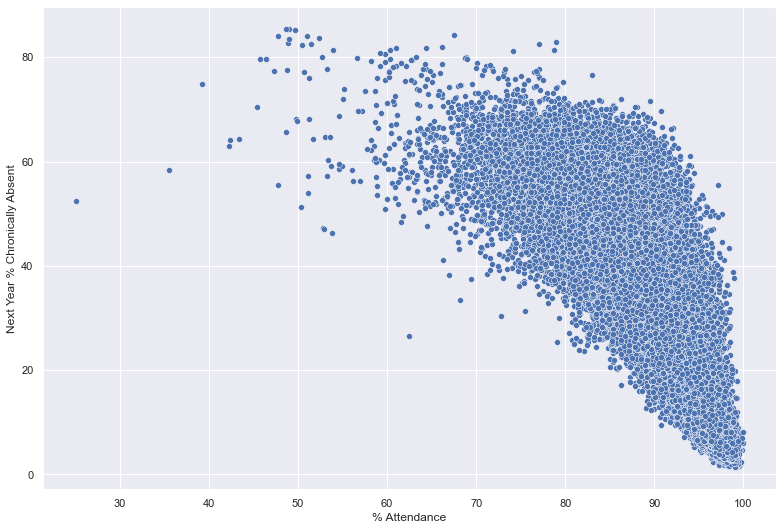

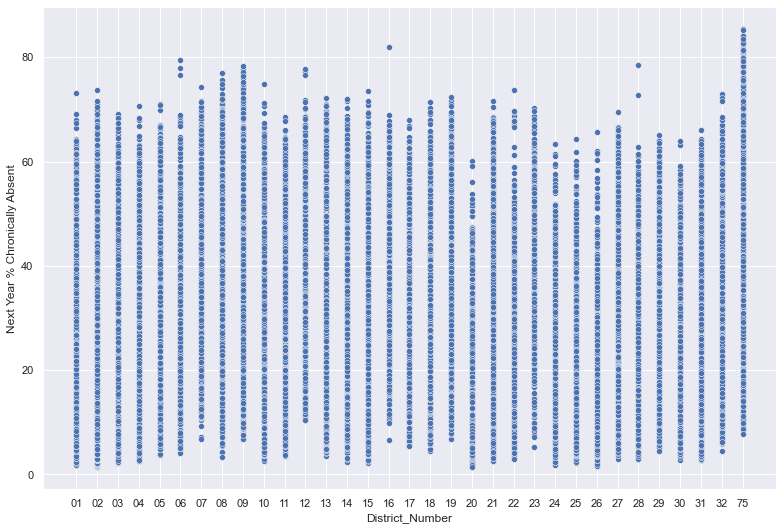

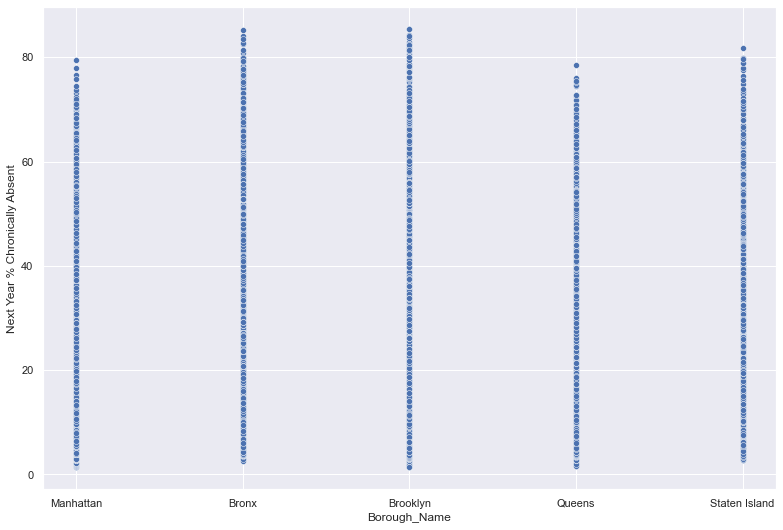

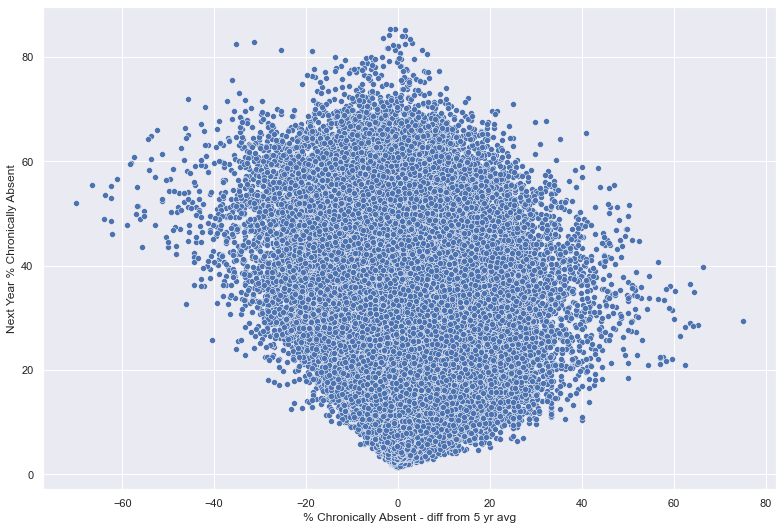

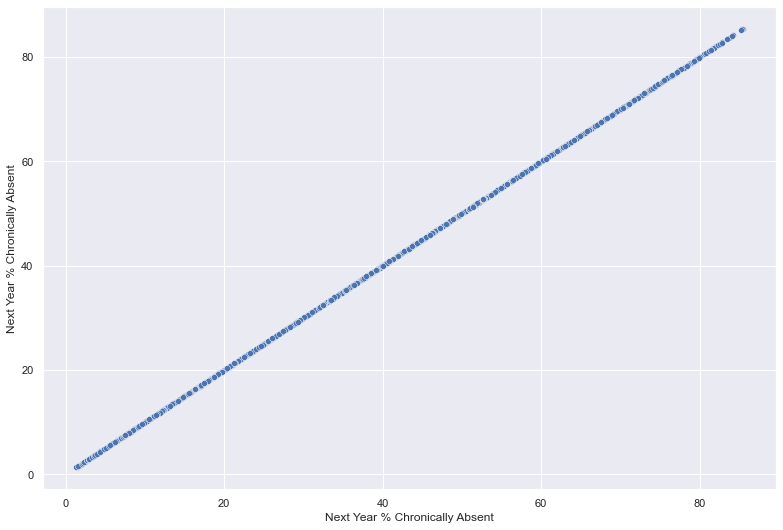

In [172]:
#plot scatterplots of all variables vs. 'Next Year % Chronically Absent'
see_target_interactions(attendance_18_19, 'Next Year % Chronically Absent')

In [ ]:
attendance_18_19.describe()

## Look for schools that have low chronic absenteeism for:
- grades 9-12
- PreK & K
- SWD
- Black, Hispanic

These are schools that are doing well in the variables with the highest rates of chronic absenteeism. They could be studied for best practices to share with others.

In [159]:
attendance_18_19['Demographic Variable'].unique()

array(['All Students', 'Not SWD', 'SWD', 'Asian', 'Black', 'Hispanic',
       'Other', 'White', 'Female', 'Male', 'Not Poverty', 'Poverty',
       'ELL', 'Not ELL'], dtype=object)

In [ ]:
attendance_18_19

In [59]:
#filter data for Low Chronically Absent Next Year
low_chronic_absent = attendance_18_19[attendance_18_19['Chronically_Absent_Next_Year'] == 'Low']

In [161]:
#list of schools with lowest % Chronically Absent predicted for black students in 2019-20
attendance_18_19[attendance_18_19['Demographic Variable'] == 'Black'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(10)

School Name  % Attendance  \
0                   Manhattan Village Academy         98.28   
1                        Jonas Bronck Academy         98.60   
2                     East Side Middle School         97.00   
3  Knowledge and Power Preparatory Academy VI         97.05   
4                                   P.S. K134         97.10   
5                                     P.S. 89         96.90   
6              P.S. 101 School in the Gardens         96.50   
7                         P.S. 018 Winchester         96.46   
8              P.S. 205 Alexander Graham Bell         96.60   
9       The Math & Science Exploratory School         96.50   

   % Chronically Absent  % Attendance - diff from 5 yr avg  \
0                 2.760                             -0.071   
1                 2.325                             -0.080   
2                 7.700                             -0.300   
3                 2.750                             -0.305   
4                 4.500                             -0.375   
5                 0.000                              0.880   
6                 4.800                             -0.300   
7                 3.600                              0.323   
8                 0.000                              1.220   
9                 8.100                              0.200   

   % Attendance - diff from 2 yr avg  \
0                            -0.0100   
1                            -0.6250   
2                            -0.2500   
3                            -0.1625   
4                            -0.4500   
5                             0.1500   
6                            -0.2000   
7                            -0.0500   
8                             0.7000   
9                            -1.0500   

   % Chronically Absent - diff from 5 yr avg  \
0                                      1.702   
1                                      0.775   
2                                      3.780   
3                                      0.205   
4                                      2.750   
5                                     -4.320   
6                                      2.140   
7                                     -1.156   
8                                     -4.760   
9                                      1.260   

   % Chronically Absent - diff from 2 yr avg  Next Year % Chronically Absent  
0                                     2.7600                        4.237975  
1                                     2.3250                        5.251214  
2                                     1.4500                        5.629813  
3                                     0.0625                        5.635618  
4                                     3.2500                        5.809910  
5                                     0.0000                        6.100473  
6                                     2.9000                        6.310313  
7                                     0.1200                        6.531179  
8                                     0.0000                        7.022166  
9                                     4.8000                        7.101922

In [94]:
#plot top schools for lowest next year chronic absenteesim in 'Black' students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Black'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

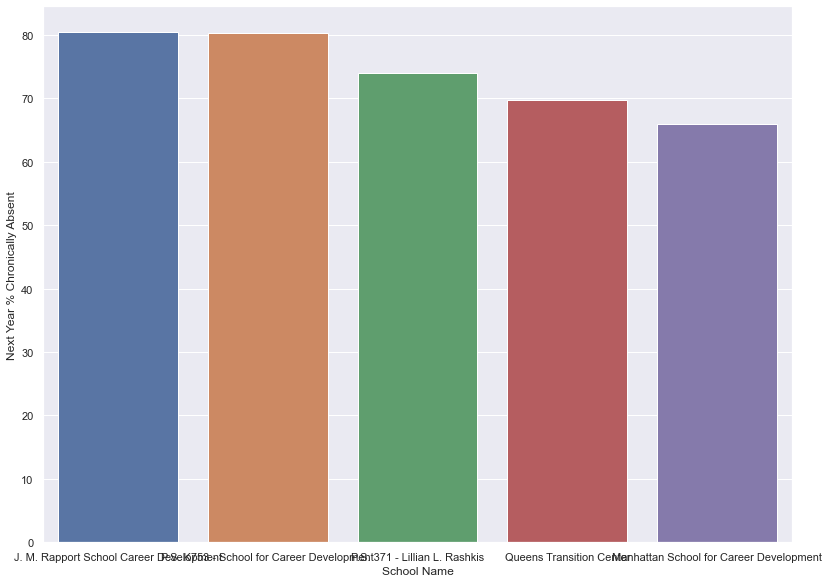

In [95]:
#plot worst schools for highest next year chronic absenteesim in 'Black' students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Black'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

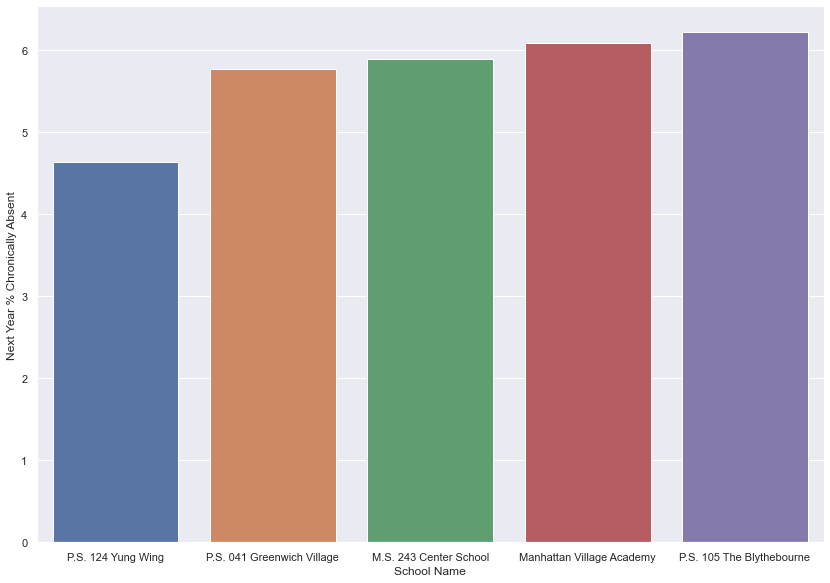

In [49]:
#plot top schools for lowest next year chronic absenteesim in 'SWD' (students with disabilities)
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'SWD'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

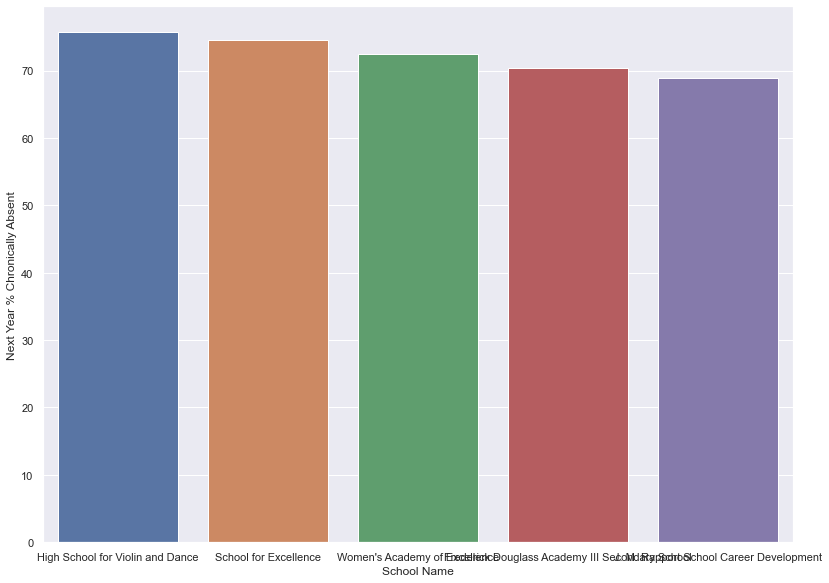

In [96]:
#plot worst schools for highest next year chronic absenteesim in 'SWD' (students with disabilities)
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'SWD'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

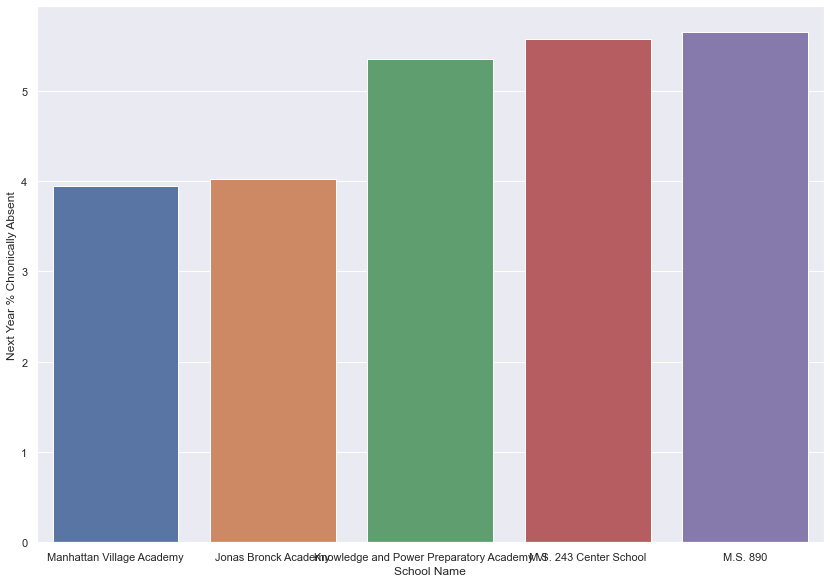

In [50]:
#plot top schools for lowest next year chronic absenteesim in 'Hispanic' students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Hispanic'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

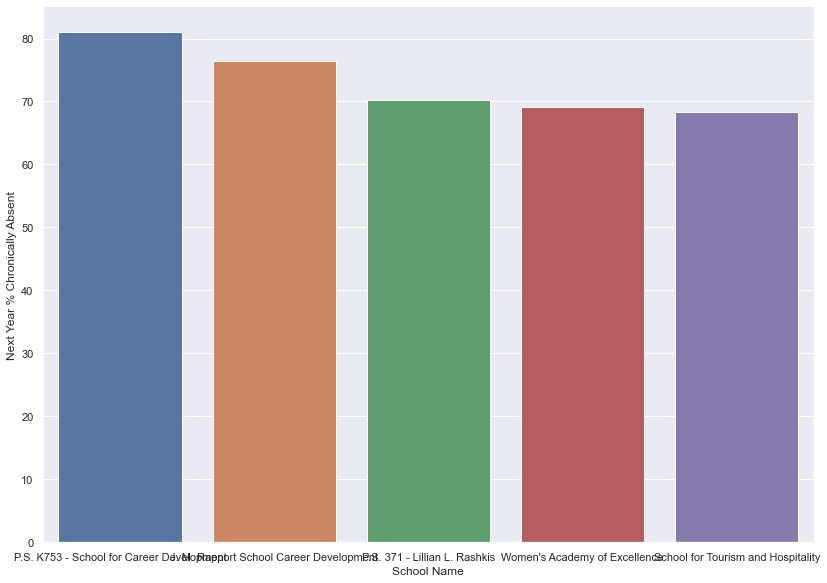

In [97]:
#plot worst schools for highest next year chronic absenteesim in 'Hispanic' students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Hispanic'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

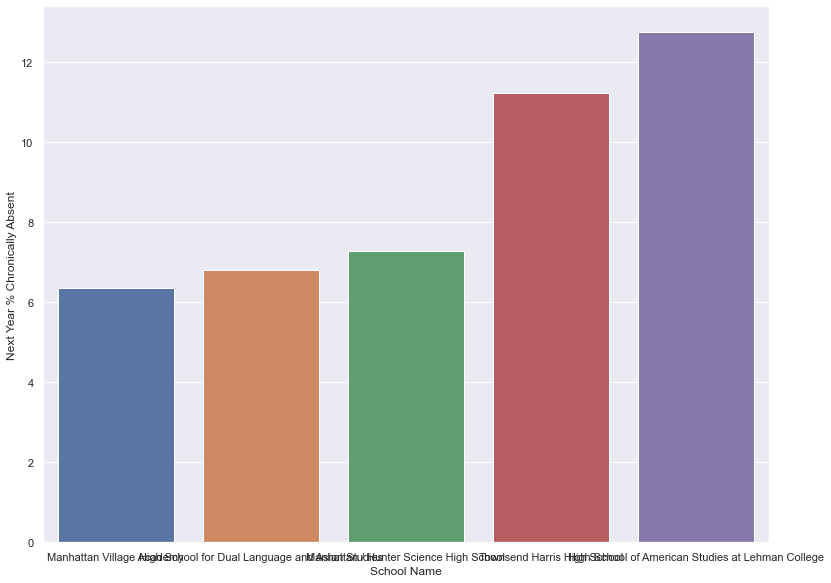

In [51]:
#plot top schools for lowest next year chronic absenteesim in Grade 12 students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '12'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

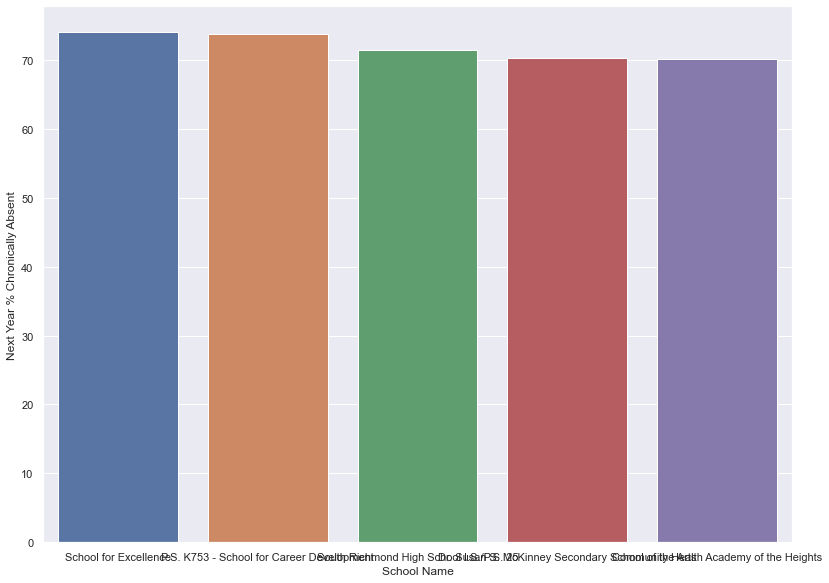

In [98]:
#plot worst schools for hightest next year chronic absenteesim in Grade 12 students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '12'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

In [100]:
#plot top schools for lowest next year chronic absenteesim in Grades 9-12 students
grades = ['9', '10', '11', '12']

ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'].isin(grades)].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

In [99]:
#plot worst schools for highest next year chronic absenteesim in Grades 9-12 students
grades = ['9', '10', '11', '12']

ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'].isin(grades)].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

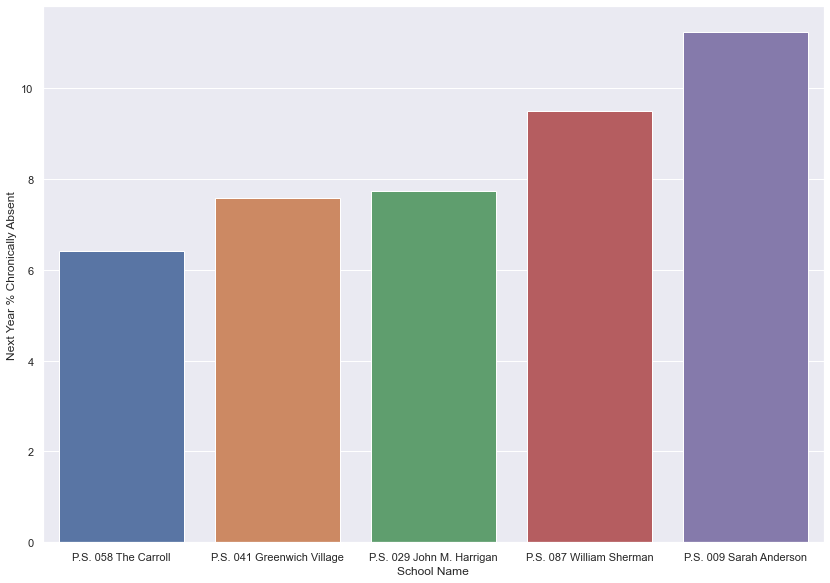

In [53]:
#plot top schools for lowest next year chronic absenteesim in PK in K-12 Schools students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == 'PK in K-12 Schools'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

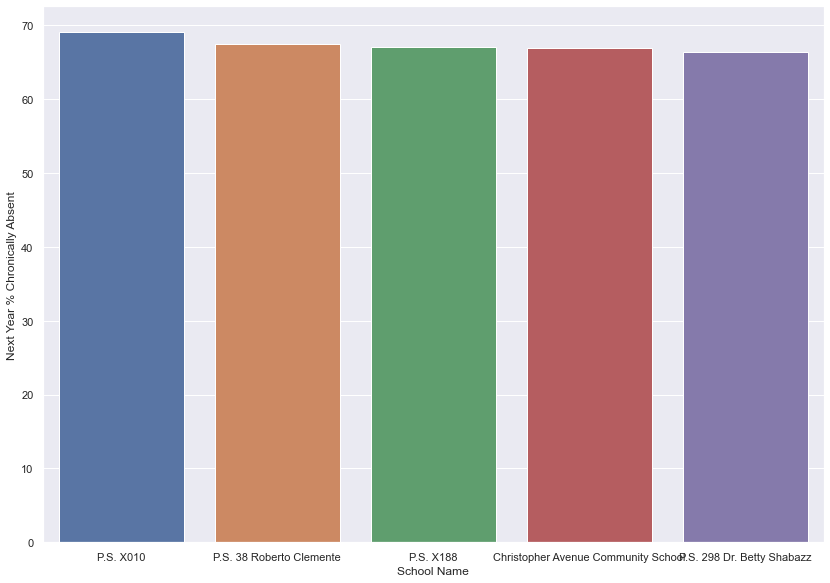

In [101]:
#plot worst schools for highest next year chronic absenteesim in PK in K-12 Schools students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == 'PK in K-12 Schools'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

In [54]:
#plot top schools for lowest next year chronic absenteesim in PK in K-12 Schools students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '0K'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

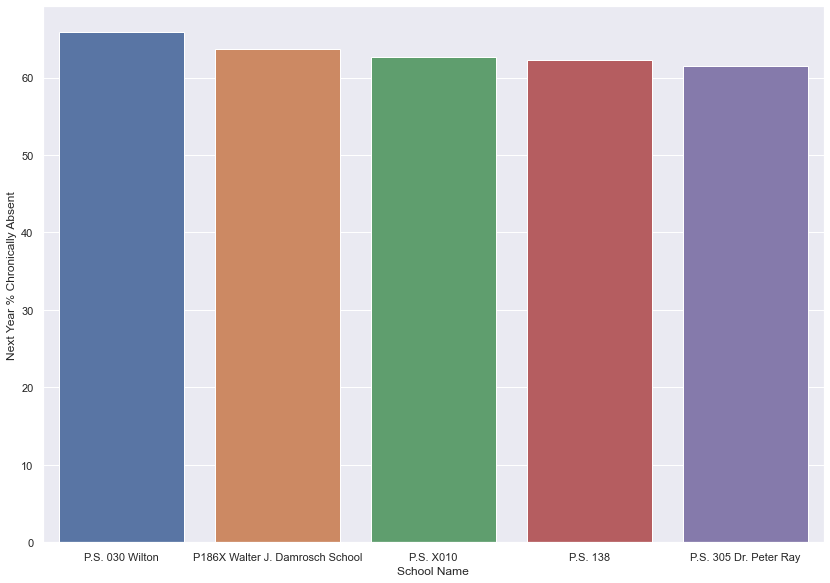

In [102]:
#plot wosrt schools for highest next year chronic absenteesim in PK in K-12 Schools students
ax = sns.barplot(x='School Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '0K'].groupby(by='School Name').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

## Look by boroughs for lowest chronic absenteeism for:
- grades 9-12
- PreK & K
- SWD
- Black, Hispanic

This shows boroughs that are doing well in the variables with the highest rates of chronic absenteeism. They could be studied for best practices to share with others.

In [56]:
#plot top boroughs for lowest next year chronic absenteesim in 'Black' students

ax = sns.barplot(x='Borough_Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Black'].groupby(by='Borough_Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

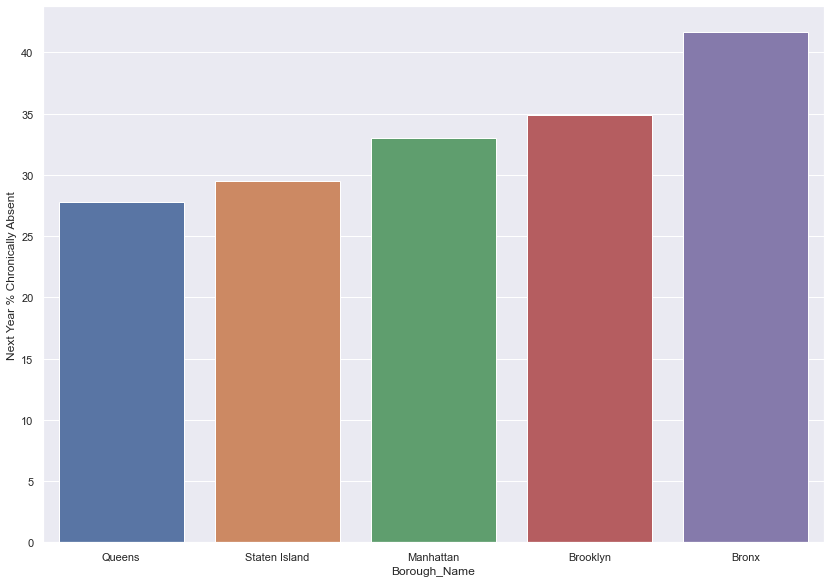

In [104]:
#plot top boroughs for lowest next year chronic absenteesim in 'SWD' (students with disabilities)
ax = sns.barplot(x='Borough_Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'SWD'].groupby(by='Borough_Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

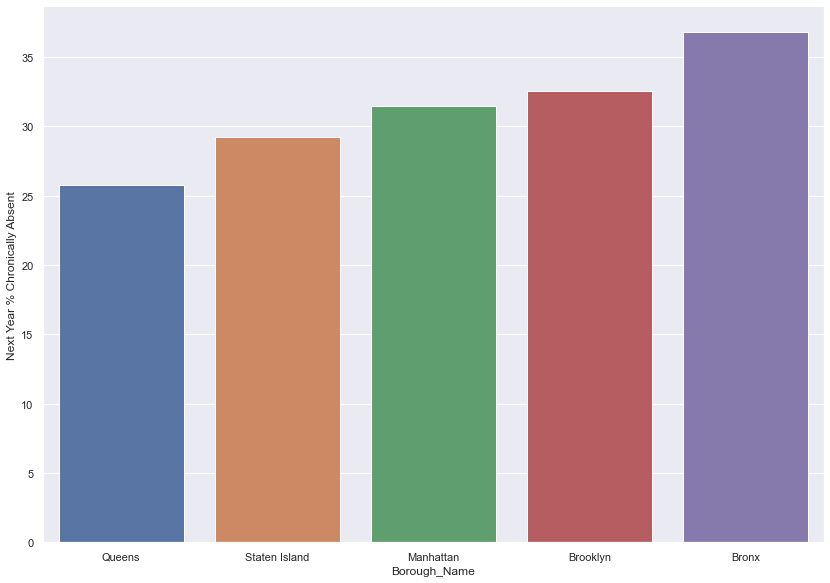

In [58]:
#plot top boroughs for lowest next year chronic absenteesim in 'Hispanic' students
ax = sns.barplot(x='Borough_Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Hispanic'].groupby(by='Borough_Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

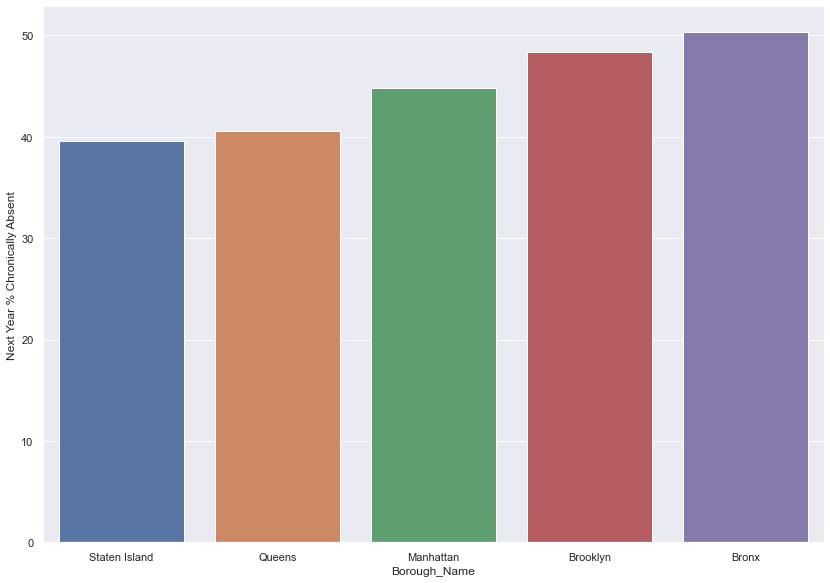

In [59]:
#plot top boroughs for lowest next year chronic absenteesim in Grade 12 students
ax = sns.barplot(x='Borough_Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '12'].groupby(by='Borough_Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

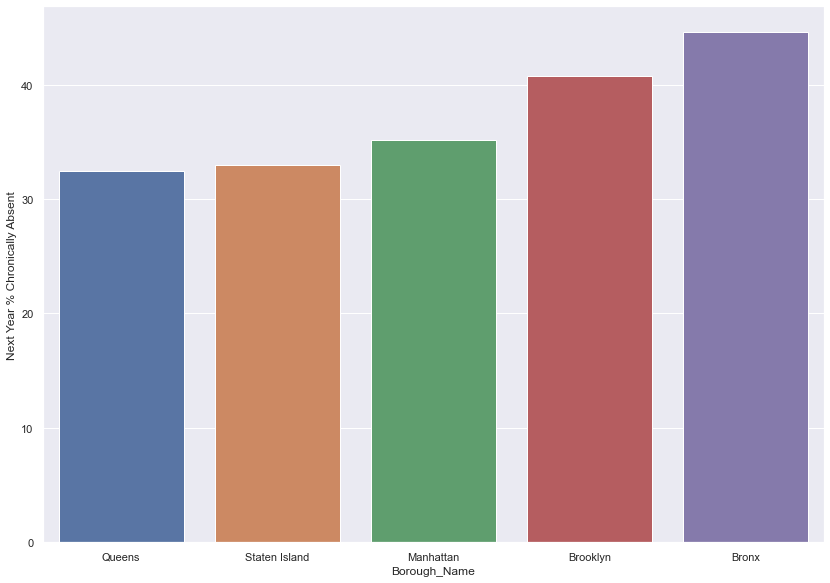

In [61]:
#plot top boroughs for lowest next year chronic absenteesim in Grades 9-12 students
#(higher number = more instances)
grades = ['9', '10', '11', '12']
ax = sns.barplot(x='Borough_Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'].isin(grades)].groupby(by='Borough_Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

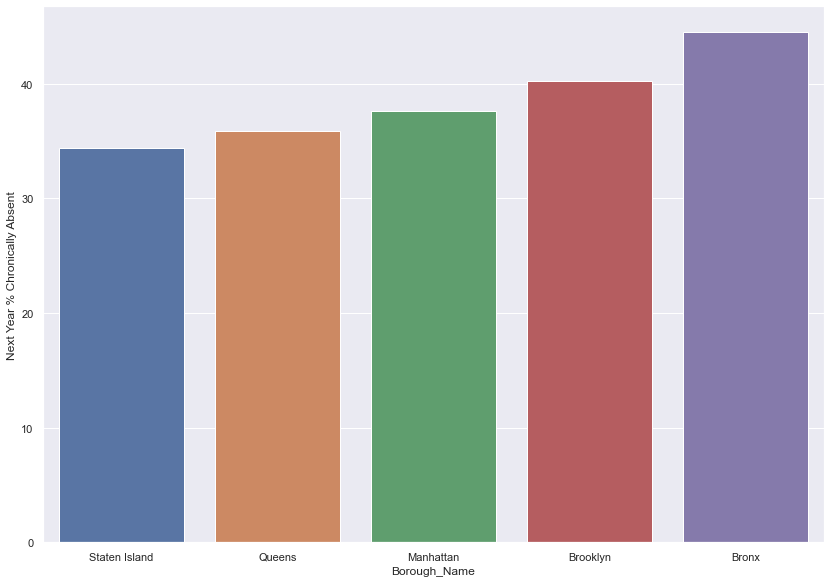

In [62]:
#plot top boroughs for lowest next year chronic absenteesim in PK in K-12 Schools students
ax = sns.barplot(x='Borough_Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == 'PK in K-12 Schools'].groupby(by='Borough_Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

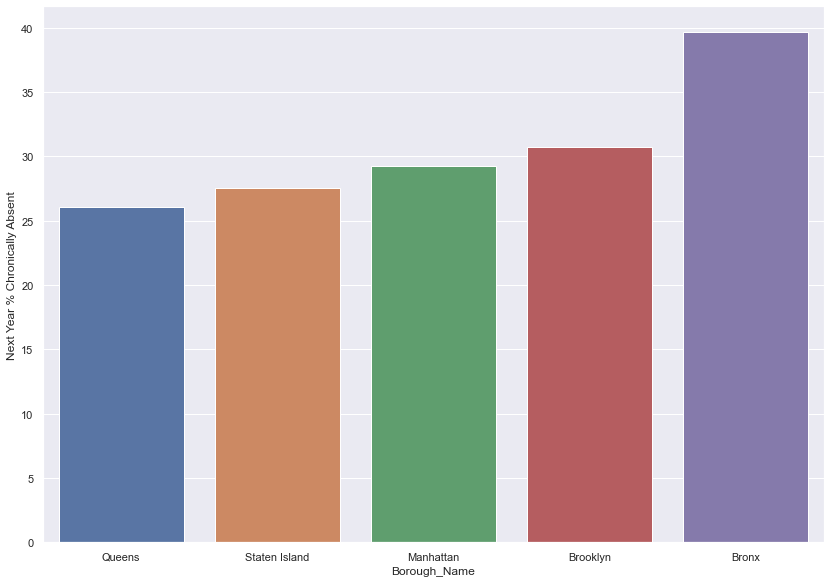

In [63]:
#plot top boroughs for lowest next year chronic absenteesim in 0K in K-12 Schools students
ax = sns.barplot(x='Borough_Name', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '0K'].groupby(by='Borough_Name').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

## Look for districts that have low chronic absenteeism for:
- grades 9-12
- PreK & K
- SWD
- Black, Hispanic

These are districs that are doing well in the variables with the highest rates of chronic absenteeism. They could be studied for best practices to share with others.

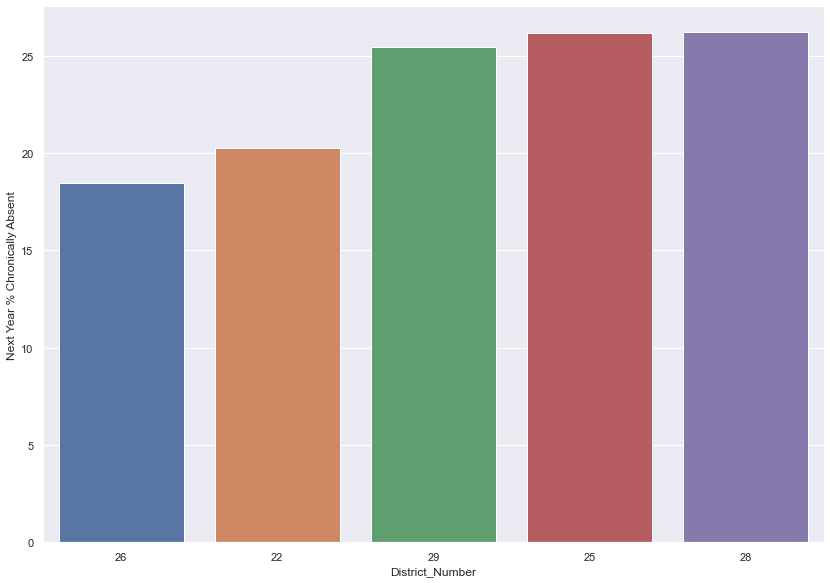

In [64]:
#plot top districts for lowest next year chronic absenteesim in 'Black' students
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Black'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

In [105]:
#plot worst districts for highest next year chronic absenteesim in 'Black' students
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Black'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

In [65]:
#plot top districts for lowest next year chronic absenteesim in 'SWD' (students with disabilities)
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'SWD'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

In [106]:
#plot worst districts for highest next year chronic absenteesim in 'SWD' (students with disabilities)
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'SWD'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

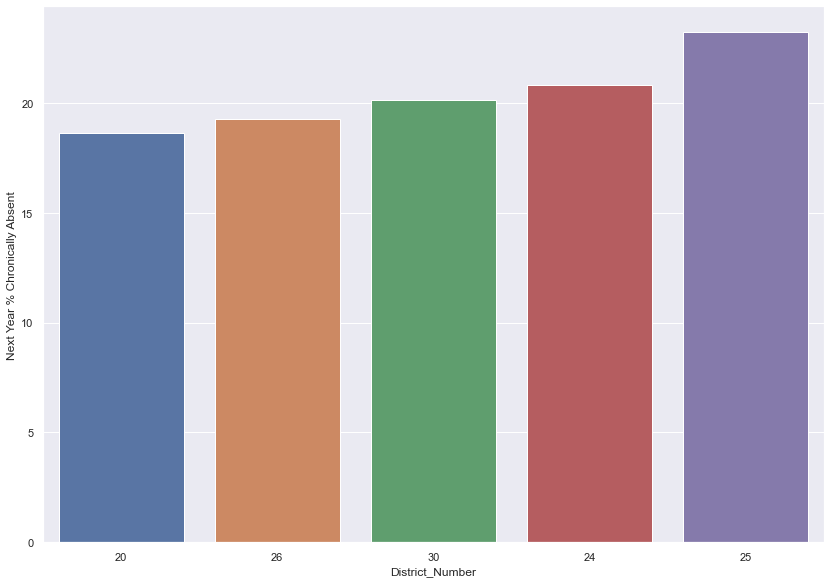

In [66]:
#plot top schools for lowest next year chronic absenteesim in 'Hispanic' students
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Hispanic'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

In [107]:
#plot worst districts for highest next year chronic absenteesim in 'Hispanic' students
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Demographic Variable'] == 'Hispanic'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

In [67]:
#plot top districts for lowest next year chronic absenteesim in Grade 12 students
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '12'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

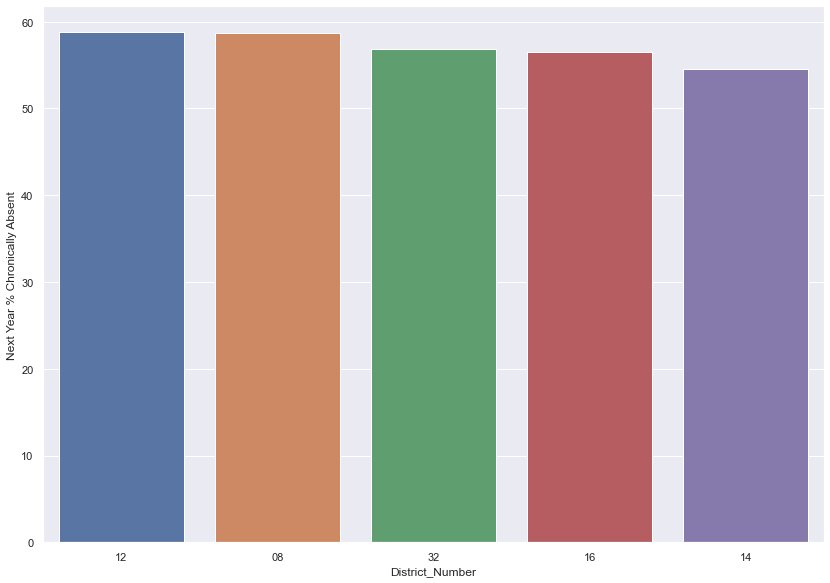

In [108]:
#plot worst districts for highest next year chronic absenteesim in Grade 12 students
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '12'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

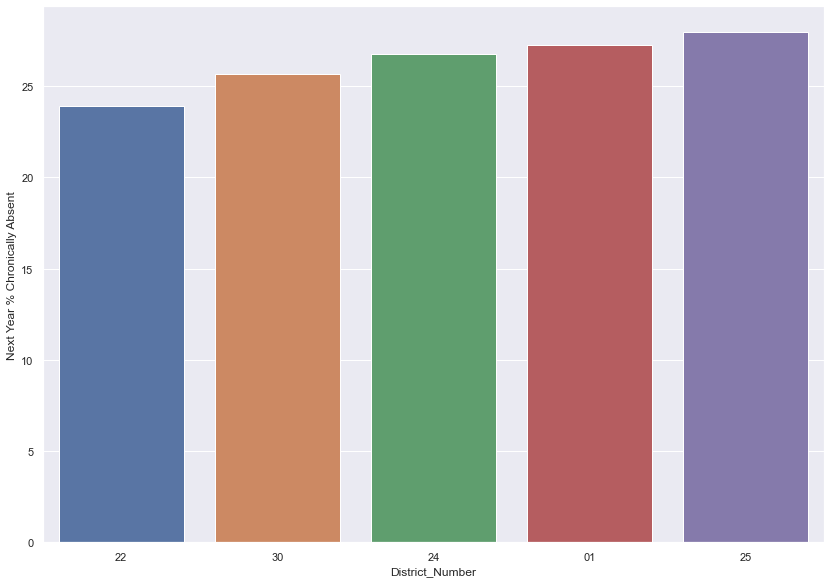

In [68]:
#plot top districts for lowest next year chronic absenteesim in Grades 9-12 students
#(higher number = more instances)
grades = ['9', '10', '11', '12']

ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'].isin(grades)].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

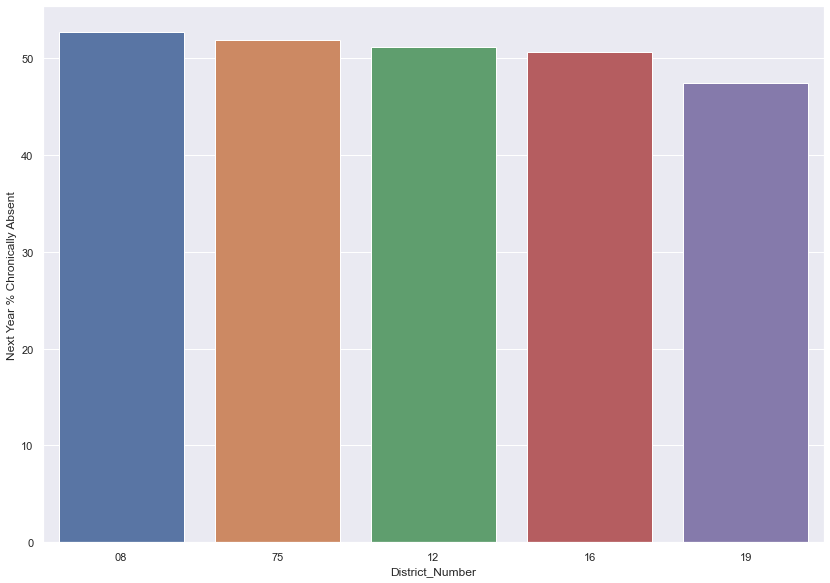

In [109]:
#plot worst districts for highest next year chronic absenteesim in Grades 9-12 students
#(higher number = more instances)
grades = ['9', '10', '11', '12']

ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'].isin(grades)].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

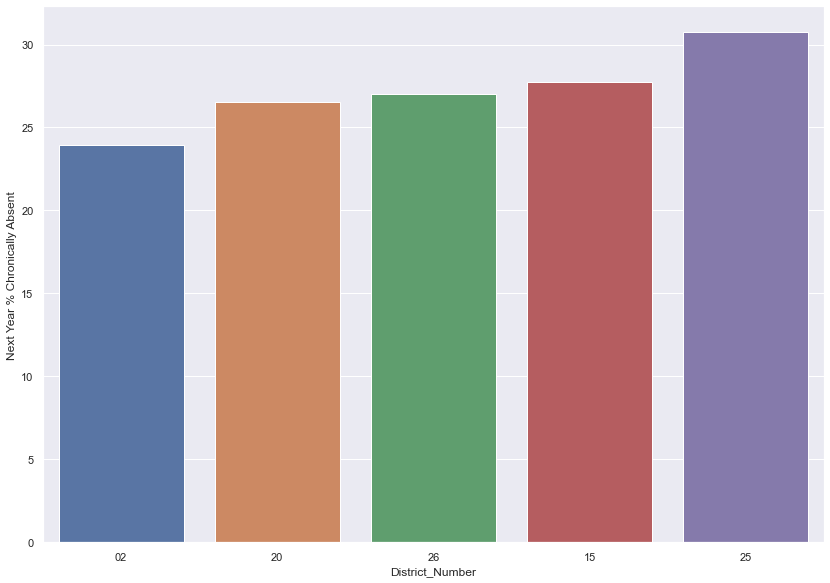

In [69]:
#plot top districts for lowest next year chronic absenteesim in PK in K-12 Schools students
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == 'PK in K-12 Schools'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

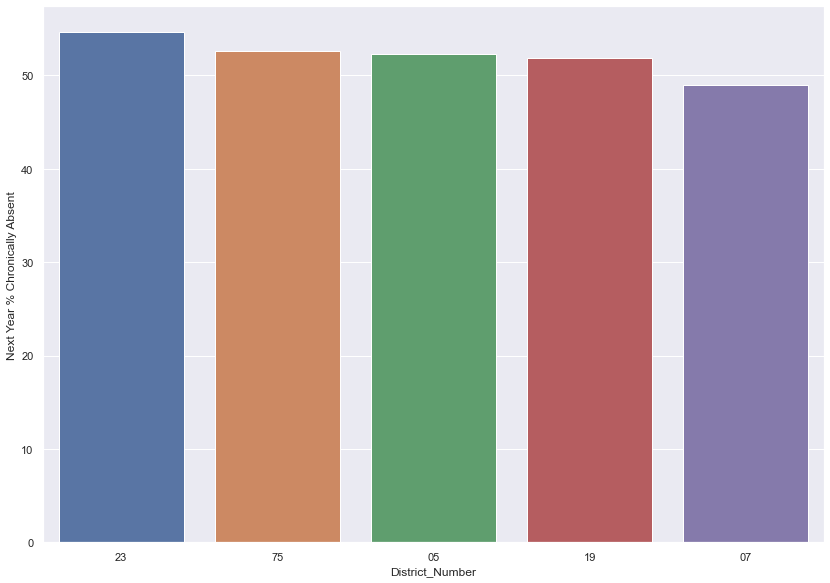

In [110]:
#plot worst districts for highest next year chronic absenteesim in PK in K-12 Schools students
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == 'PK in K-12 Schools'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

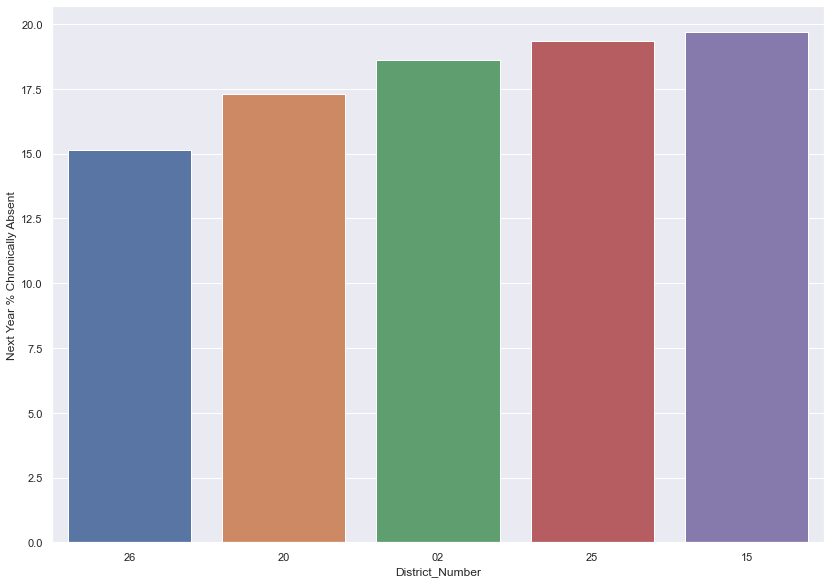

In [70]:
#plot top schools for lowest next year chronic absenteesim in 0K in K-12 Schools students
#(higher number = more instances)
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '0K'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent').reset_index().head(5))
plt.tight_layout()
plt.show()

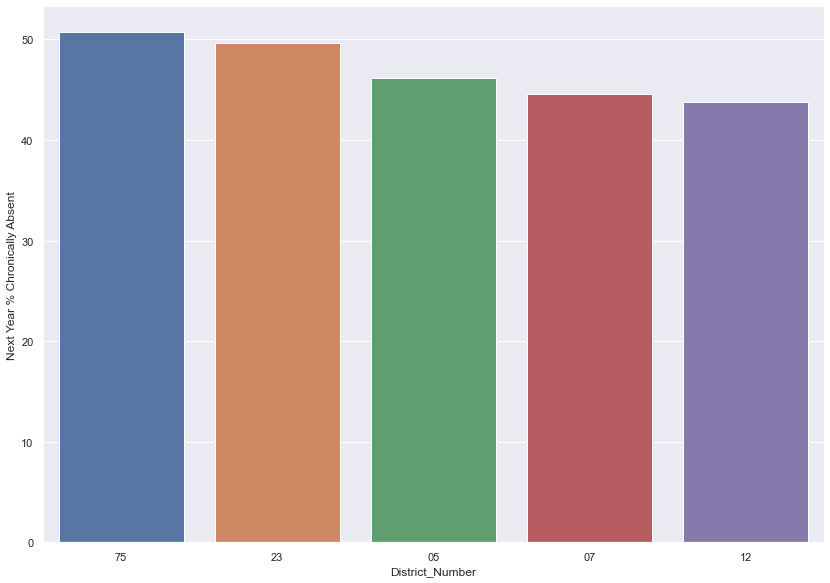

In [111]:
#plot worst districts for highest next year chronic absenteesim in 0K in K-12 Schools students
#(higher number = more instances)
ax = sns.barplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance_18_19[attendance_18_19['Grade'] == '0K'].groupby(by='District_Number').mean().sort_values(by='Next Year % Chronically Absent', ascending=False).reset_index().head(5))
plt.tight_layout()
plt.show()

In [74]:
#check len of all attendance data
len(attendance)

583265

In [75]:
#concat attendance 2013-14 thru 2017-18 with 2018-19 predicted data
attendance_full = pd.concat([attendance[attendance.Year != '2018-19'], attendance_18_19])
attendance_full.head()

DBN                School Name               Grade     Year  \
0  01M015  P.S. 015 Roberto Clemente          All Grades  2013-14   
1  01M015  P.S. 015 Roberto Clemente  PK in K-12 Schools  2013-14   
2  01M015  P.S. 015 Roberto Clemente                  0K  2013-14   
3  01M015  P.S. 015 Roberto Clemente                   1  2013-14   
4  01M015  P.S. 015 Roberto Clemente                   2  2013-14   

  Demographic Variable  % Attendance  % Chronically Absent  \
0         All Students          92.0                  26.9   
1         All Students          88.1                  53.3   
2         All Students          90.7                  29.5   
3         All Students          92.2                  31.0   
4         All Students          92.3                  20.0   

   Next Year % Chronically Absent Chronically_Absent_Next_Year  \
0                            23.4                       Medium   
1                            65.2                         High   
2                            30.0                       Medium   
3                            18.8                       Medium   
4                            21.9                       Medium   

  District_Number Borough_Name  % Attendance - diff from 5 yr avg  \
0              01    Manhattan                             -1.060   
1              01    Manhattan                             -0.675   
2              01    Manhattan                             -1.020   
3              01    Manhattan                             -0.960   
4              01    Manhattan                             -1.320   

   % Attendance - diff from 2 yr avg  \
0                              -1.65   
1                              -4.50   
2                              -1.85   
3                              -1.75   
4                              -1.45   

   % Chronically Absent - diff from 5 yr avg  \
0                                      2.580   
1                                      5.625   
2                                     -1.060   
3                                      5.360   
4                                      0.460   

   % Chronically Absent - diff from 2 yr avg  
0                                       4.95  
1                                      31.10  
2                                      -0.95  
3                                      14.55  
4                                      -0.60

In [76]:
#check NaNs as percent 
NaNs_as_percent(attendance_full)

DBN                                          0.000000
School Name                                  0.000000
Grade                                        0.000000
Year                                         0.000000
Demographic Variable                         0.000000
% Attendance                                 0.000000
% Chronically Absent                         0.000000
Next Year % Chronically Absent               6.270049
Chronically_Absent_Next_Year                 6.270049
District_Number                              0.000000
Borough_Name                                 0.000000
% Attendance - diff from 5 yr avg            0.000000
% Attendance - diff from 2 yr avg            0.000000
% Chronically Absent - diff from 5 yr avg    0.000000
% Chronically Absent - diff from 2 yr avg    0.000000
dtype: float64


In [86]:
#see mean data sorted by year
attendance_full.groupby(by='Year').mean().sort_values(by='Year').reset_index()

Year  % Attendance  % Chronically Absent  \
0  2013-14     91.087702             27.957149   
1  2014-15     91.573026             26.273545   
2  2015-16     91.686732             26.039595   
3  2016-17     91.358475             27.369469   
4  2017-18     91.172230             28.794973   
5  2018-19     91.295671             28.544893   

   Next Year % Chronically Absent  % Attendance - diff from 5 yr avg  \
0                       26.074476                          -0.268878   
1                       25.905290                           0.203329   
2                       27.188226                           0.308932   
3                       28.648813                           0.007914   
4                       28.393852                          -0.247781   
5                       27.475318                          -0.197762   

   % Attendance - diff from 2 yr avg  \
0                          -0.166524   
1                           0.322822   
2                           0.440101   
3                           0.121165   
4                          -0.121064   
5                          -0.075030   

   % Chronically Absent - diff from 5 yr avg  \
0                                   0.675070   
1                                  -1.006235   
2                                  -1.232538   
3                                  -0.064310   
4                                   1.549784   
5                                   1.578850   

   % Chronically Absent - diff from 2 yr avg  
0                                  -0.061253  
1                                  -1.782950  
2                                  -2.034689  
3                                  -0.767205  
4                                   0.766568  
5                                   0.810310

<AxesSubplot:xlabel='Year', ylabel='Next Year % Chronically Absent'>

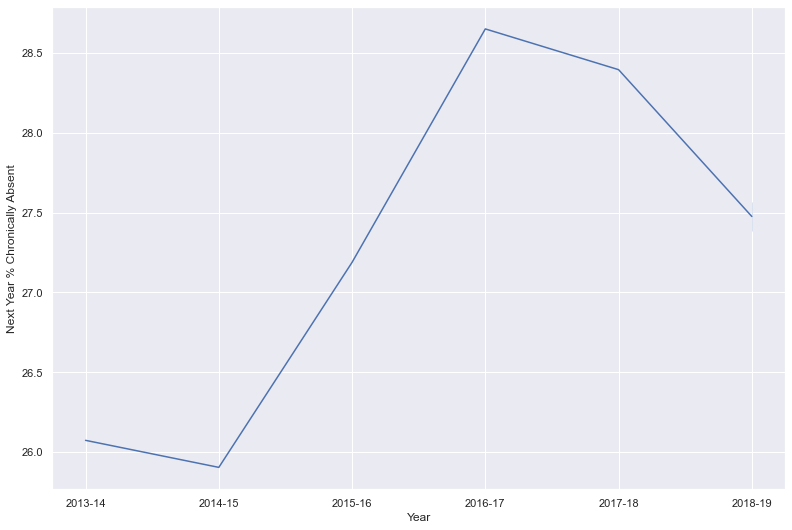

In [78]:
#lineplot of 'Next Year % Chronically Absent' across time
#not consistent with covid-19
sns.lineplot(x='Year', y='Next Year % Chronically Absent', data=attendance_full)

In [88]:
#see mean data sorted by year/Grade
attendance_full.groupby(by=['Grade','Year']).mean().sort_values(by='Grade').reset_index()

Grade     Year  % Attendance  % Chronically Absent  \
0                   0K  2013-14     91.164788             31.919887   
1                   0K  2014-15     91.618406             29.825125   
2                   0K  2015-16     91.834646             29.536486   
3                   0K  2016-17     91.461399             31.002834   
4                   0K  2017-18     91.207195             32.577419   
..                 ...      ...           ...                   ...   
85  PK in K-12 Schools  2015-16     90.386162             36.177914   
86  PK in K-12 Schools  2017-18     89.573314             40.169201   
87  PK in K-12 Schools  2013-14     89.384133             41.529274   
88  PK in K-12 Schools  2014-15     89.578354             41.281252   
89  PK in K-12 Schools  2018-19     89.501040             40.948707   

    Next Year % Chronically Absent  % Attendance - diff from 5 yr avg  \
0                        29.515416                          -0.275770   
1                        29.351863                           0.156966   
2                        30.460947                           0.338643   
3                        32.241314                           0.049121   
4                        32.689218                          -0.262080   
..                             ...                                ...   
85                       37.194449                           0.523877   
86                       40.476159                          -0.240551   
87                       40.698287                          -0.406216   
88                       35.627580                          -0.235684   
89                       38.668773                          -0.286771   

    % Attendance - diff from 2 yr avg  \
0                           -0.167110   
1                            0.273880   
2                            0.461135   
3                            0.143726   
4                           -0.143891   
..                                ...   
85                           0.577386   
86                          -0.222855   
87                          -0.477962   
88                          -0.299839   
89                          -0.274701   

    % Chronically Absent - diff from 5 yr avg  \
0                                    0.850520   
1                                   -1.138359   
2                                   -1.236271   
3                                   -0.234454   
4                                    1.672216   
..                                        ...   
85                                  -2.887567   
86                                   0.932708   
87                                   2.074711   
88                                   1.961605   
89                                   1.535489   

    % Chronically Absent - diff from 2 yr avg  
0                                    0.108612  
1                                   -1.919366  
2                                   -2.032166  
3                                   -0.863895  
4                                    0.864888  
..                                        ...  
85                                  -2.873006  
86                                   1.111198  
87                                   2.732739  
88                                   2.634079  
89                                   1.789833  

[90 rows x 9 columns]

<AxesSubplot:xlabel='Year', ylabel='Next Year % Chronically Absent'>

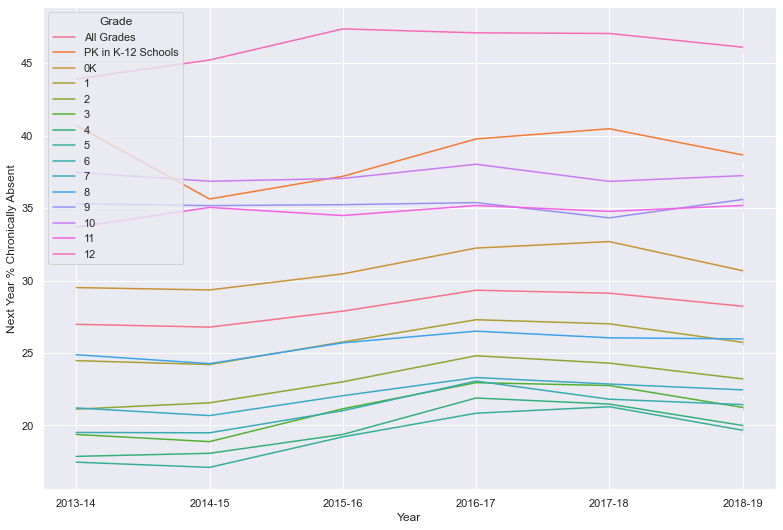

In [80]:
#lineplot of 'Next Year % Chronically Absent' across time by Grade
sns.lineplot(x='Year', y='Next Year % Chronically Absent', hue='Grade', data=attendance_full)

In [89]:
#see mean data sorted by year/demographic variable
attendance_full.groupby(by=['Demographic Variable','Year']).mean().sort_values(by='Demographic Variable').reset_index()

Demographic Variable     Year  % Attendance  % Chronically Absent  \
0          All Students  2013-14     90.995439             28.886584   
1          All Students  2014-15     91.485145             27.217661   
2          All Students  2015-16     91.619660             26.831308   
3          All Students  2016-17     91.289988             28.086483   
4          All Students  2017-18     90.988259             30.004242   
..                  ...      ...           ...                   ...   
79                White  2013-14     92.995816             19.075958   
80                White  2014-15     93.410064             17.345304   
81                White  2015-16     93.421116             17.721653   
82                White  2016-17     93.036657             19.369171   
83                White  2018-19     93.176769             19.295205   

    Next Year % Chronically Absent  % Attendance - diff from 5 yr avg  \
0                        27.020541                          -0.281553   
1                        26.727320                           0.210964   
2                        27.932919                           0.348812   
3                        29.909166                           0.036757   
4                        29.717506                          -0.318657   
..                             ...                                ...   
79                       16.293933                          -0.331344   
80                       16.607797                           0.163840   
81                       18.131599                           0.229519   
82                       19.613443                           0.046203   
83                       19.636918                          -0.004376   

    % Attendance - diff from 2 yr avg  \
0                           -0.151383   
1                            0.348320   
2                            0.493561   
3                            0.176031   
4                           -0.175691   
..                                ...   
79                          -0.291485   
80                           0.199860   
81                           0.297102   
82                           0.072170   
83                           0.035346   

    % Chronically Absent - diff from 5 yr avg  \
0                                    0.734689   
1                                   -0.994356   
2                                   -1.367773   
3                                   -0.214940   
4                                    1.826634   
..                                        ...   
79                                   1.056109   
80                                  -0.914356   
81                                  -0.911005   
82                                  -0.200947   
83                                   0.520541   

    % Chronically Absent - diff from 2 yr avg  
0                                   -0.068705  
1                                   -1.819536  
2                                   -2.196215  
3                                   -1.009881  
4                                    1.007929  
..                                        ...  
79                                   0.656232  
80                                  -1.301318  
81                                  -1.367521  
82                                  -0.525735  
83                                   0.155872  

[84 rows x 9 columns]

<AxesSubplot:xlabel='Year', ylabel='Next Year % Chronically Absent'>

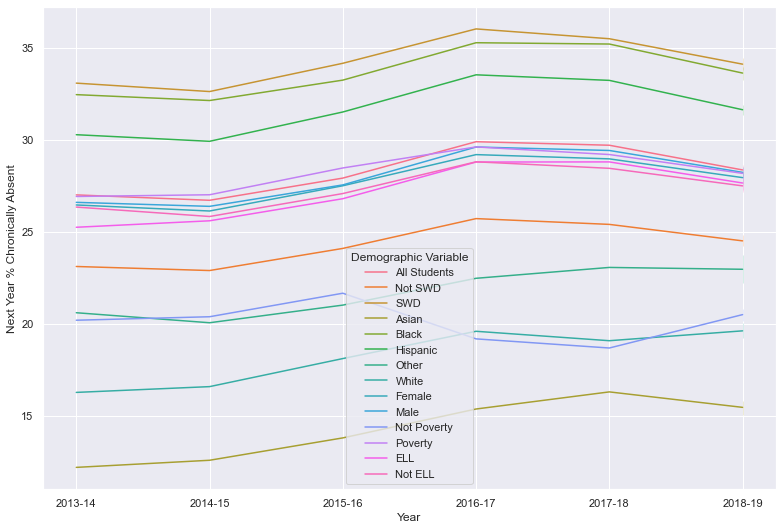

In [81]:
#lineplot of 'Next Year % Chronically Absent' across time by Demograhic Variable
sns.lineplot(x='Year', y='Next Year % Chronically Absent', hue='Demographic Variable', data=attendance_full)

In [91]:
#see mean data sorted by year/borough_Name
attendance_full.groupby(by=['Borough_Name','Year']).mean().sort_values(by='Borough_Name').reset_index().head(10)

Borough_Name     Year  % Attendance  % Chronically Absent  \
0        Bronx  2013-14     89.300929             35.690872   
1        Bronx  2014-15     89.791599             33.688050   
2        Bronx  2015-16     89.958151             32.765193   
3        Bronx  2016-17     89.470185             34.793936   
4        Bronx  2017-18     89.351546             36.282598   
5        Bronx  2018-19     89.733662             35.209450   
6     Brooklyn  2013-14     90.779561             28.998463   
7     Brooklyn  2014-15     91.300325             27.248210   
8     Brooklyn  2015-16     91.383632             27.239638   
9     Brooklyn  2016-17     91.125716             28.387601   

   Next Year % Chronically Absent  % Attendance - diff from 5 yr avg  \
0                       33.600256                          -0.273729   
1                       32.808335                           0.226098   
2                       34.746288                           0.390420   
3                       36.423212                          -0.055466   
4                       35.157291                          -0.281762   
5                       34.361922                           0.012418   
6                       27.017902                          -0.268728   
7                       26.979377                           0.199552   
8                       28.081442                           0.281776   
9                       29.499122                           0.042930   

   % Attendance - diff from 2 yr avg  \
0                          -0.141876   
1                           0.378774   
2                           0.547543   
3                           0.105838   
4                          -0.107649   
5                           0.174280   
6                          -0.180070   
7                           0.309403   
8                           0.405387   
9                           0.142580   

   % Chronically Absent - diff from 5 yr avg  \
0                                   1.125226   
1                                  -0.986489   
2                                  -1.858394   
3                                   0.002686   
4                                   1.682681   
5                                   0.885139   
6                                   0.522591   
7                                  -1.035898   
8                                  -1.066330   
9                                  -0.119911   

   % Chronically Absent - diff from 2 yr avg  
0                                   0.359717  
1                                  -1.825586  
2                                  -2.710918  
3                                  -0.783651  
4                                   0.797061  
5                                   0.062485  
6                                  -0.227851  
7                                  -1.824699  
8                                  -1.869092  
9                                  -0.817013

<AxesSubplot:xlabel='Year', ylabel='Next Year % Chronically Absent'>

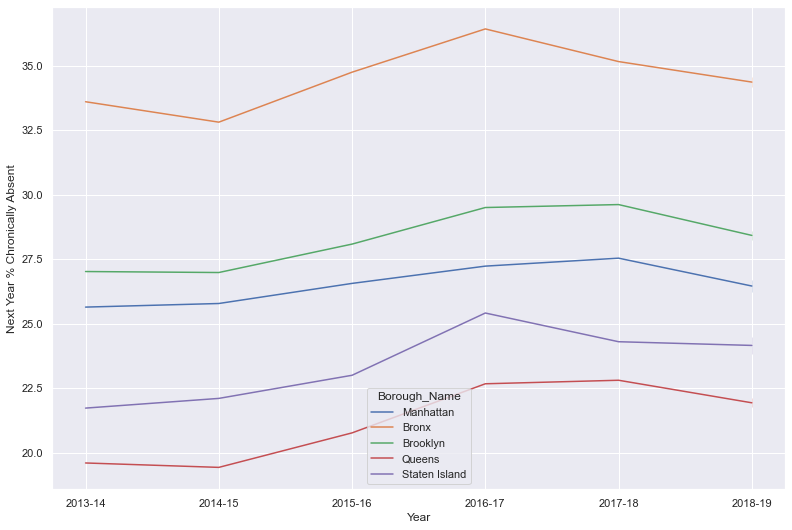

In [82]:
#lineplot of 'Next Year % Chronically Absent' across time by Borough Name
sns.lineplot(x='Year', y='Next Year % Chronically Absent', hue='Borough_Name', data=attendance_full)

In [92]:
#see mean data sorted by year/district number
attendance_full.groupby(by=['District_Number','Year']).mean().sort_values(by='District_Number').reset_index().head(10)

District_Number     Year  % Attendance  % Chronically Absent  \
0              01  2013-14     91.734152             25.619591   
1              01  2014-15     92.456304             23.506624   
2              01  2015-16     92.851624             23.496230   
3              01  2016-17     92.744470             23.667617   
4              01  2017-18     92.442873             25.825167   
5              01  2018-19     92.148612             27.335145   
6              02  2013-14     91.775308             22.574545   
7              02  2014-15     92.216466             21.253303   
8              02  2015-16     91.886028             22.149479   
9              02  2016-17     91.651228             22.926461   

   Next Year % Chronically Absent  % Attendance - diff from 5 yr avg  \
0                       23.676386                          -0.584502   
1                       23.561226                           0.073481   
2                       23.436260                           0.371216   
3                       25.567547                           0.235282   
4                       27.058089                          -0.100013   
5                       24.524810                          -0.417169   
6                       21.512213                          -0.035920   
7                       22.293758                           0.363437   
8                       23.218533                           0.069148   
9                       23.698862                          -0.147617   

   % Attendance - diff from 2 yr avg  \
0                          -0.651111   
1                           0.008687   
2                           0.301392   
3                           0.141021   
4                          -0.137723   
5                          -0.504607   
6                           0.124944   
7                           0.555472   
8                           0.269788   
9                           0.020838   

   % Chronically Absent - diff from 5 yr avg  \
0                                   0.761278   
1                                  -1.163107   
2                                  -0.868541   
3                                  -0.578833   
4                                   1.788731   
5                                   3.496692   
6                                   0.135858   
7                                  -1.063203   
8                                  -0.364657   
9                                   0.268138   

   % Chronically Absent - diff from 2 yr avg  
0                                   0.078158  
1                                  -1.842330  
2                                  -1.451827  
3                                  -1.111887  
4                                   1.085885  
5                                   2.937773  
6                                  -0.433518  
7                                  -1.687045  
8                                  -1.030316  
9                                  -0.277590

<AxesSubplot:xlabel='Year', ylabel='Next Year % Chronically Absent'>

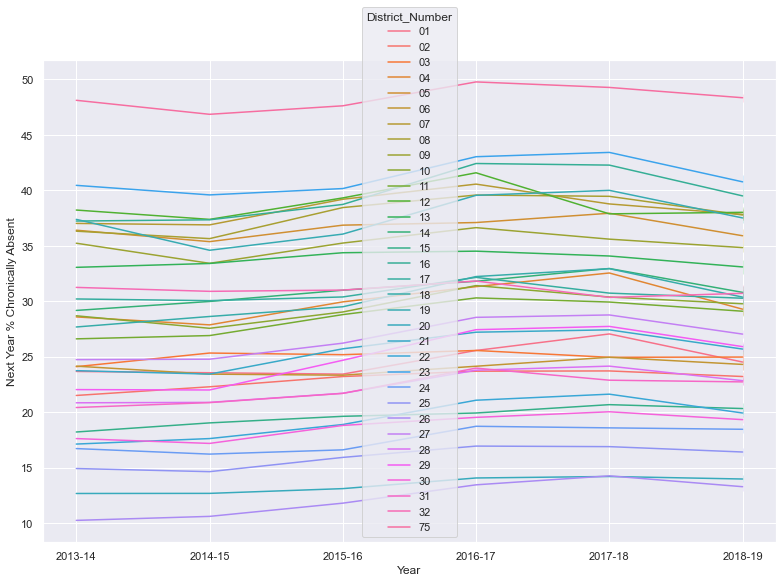

In [93]:
#lineplot of 'Next Year % Chronically Absent' across time by district number
sns.lineplot(x='Year', y='Next Year % Chronically Absent', hue='District_Number', data=attendance_full)

# Summary

- after loading data, check to ensure District Number is correctly an object, not int
- create dummy variables for the two data frames
- remove target variable from classification data, so it does not get turned into a dummy variable
- save target variable for classification
- #define variables for regressor and train test split
- loaded both the regression and classification models and tested they were showing same accuracy as before
- Refit Classification Model on All Available Data
- Calculate Expected Chronic Absenteesim for 2019-2020 From The Model¶
- from data subset of 2018-19 year drop NaN rows, for only the rows where target classification variable is NOT NaN
- from regression model, drop column that was used as classification target variable
- from classification model drop column that was used as regression target variable
- create X and y variables for years 2019-2020
- turn categorical variables into binary for predicting with get dummies
- predict next year's vacancy rate (2019-20) for school year 2018-19 (both with classification and regression models
- create new columns of predicted values
- get labels for school name & DBN (categorical columns that were dropped prior for machine learning)
- prepare attendance data for merge with 'Next Year's Chronic Absenteesim' predictions (by dropping columns not of interest)
- subset attendance to year 2018-2019
- added predicted values for next year onto 2018-19 data set, after check if lens match up 


Explore Projected 2019-20 Chronic Absenteeism Data
- look at violin plots of borough name vs. Next Year % Chronically Absent by class (High, Medium, Low). Seems like most of the variation is in the borough's 'Medium' class. This may be a good area to target in interventions
- look at violin plots of Demographic Variable vs. Next Year % Chronically Absent by class (High, Medium, Low). Again it seems like most of the variation is in the 'Medium' class. 
- look at violin plots of Demographic Variable vs. vs. Next Year % Chronically Absent. Seems like 'Asian', 'White', 'Other' (Race), and 'Not Poverty' students are significantly below the average. While SWD (Students with Disabilities), Black and Hispanic students seem to be signifiantly above the average.
- look at violin plot of District_Number vs. Next Year % Chronically Absent
- look at scatterplot '% Attendance' vs. '% Chronically Absent' colored by 'Chronically_Absent_Next_Year'. You can see the overlap/variation of the 'Medium' class
- scatterplot of '% Attendance - diff from 5 yr avg' vs. '% Chronically Absent - diff from 5 yr avg', colored by 'Chronically_Absent_Next_Year
- scatterplot '% Attendance - diff from 2 yr avg' vs. '% Chronically Absent - diff from 2 yr avg', colored by 'Chronically_Absent_Next_Year'
- These plots show there is a lot of year to year variation in the 'High' group in how they differ from their own 2 & 5 year averages. Seeming to show this group would potentially benefit from a concerted intervention.
- plot scatterplots of all variables vs. 'Next Year % Chronically Absent'

Look for schools that have low chronic absenteeism for:
- grades 9-12
- PreK & K
- SWD
- Black, Hispanic
These are schools that are doing well in the variables with the highest rates of chronic absenteeism. They could be studied for best practices to share with others.


Continue from here...¶
- plot lowest
- plot highest
- concat 18-19 w/ rest of data
- get time series of target variable,
- then look at it split by categorical values
- go back to violin plots and finish them by all categorical variables (ie. grade, borough)